In [1]:
import time
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from functools import partial
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
import re
from sklearn.ensemble import GradientBoostingClassifier
#from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
%matplotlib inline

In [2]:
df = pd.read_csv('sparse.csv')

In [93]:
# (old) Gradient boosting classifier
# Lots of parameters, but let's just see how the default does first...
gbc = GradientBoostingClassifier(learning_rate=0.25, n_estimators=1000, max_depth=5, verbose=1)
gbc.fit(train_x, train_y)
preds = gbc.predict(test_x)
gbc_cm = confusion_matrix(test_y, preds)
print(gbc_cm)
tp, fn, fp, tn = gbc_cm.ravel()
accuracy = (tp+tn)/(tp+fn+fp+tn)
precision = tp/(tp + fp)
recall = tp/(tp + fn)
F = 2*precision*recall/(precision + recall)
print('Accuracy: {:.3f}%\nPrecision: {:.3f}%\nRecall: {:.3f}%\nF: {:.3f}'.format(accuracy, precision, recall, F))

      Iter       Train Loss   Remaining Time 
         1           1.2932           30.55m
         2           1.2373           33.68m
         3           1.1949           33.42m
         4           1.1652           32.68m
         5           1.1407           32.67m
         6           1.1205           30.46m
         7           1.1042           29.57m
         8           1.0905           28.24m
         9           1.0771           26.82m
        10           1.0635           26.42m
        20           0.9727           22.15m
        30           0.9143           20.07m
        40           0.8743           18.44m
        50           0.8380           17.56m
        60           0.8059           16.82m
        70           0.7793           16.23m
        80           0.7564           15.76m
        90           0.7355           15.35m
       100           0.7139           14.99m
       200           0.5775           12.32m
       300           0.4842           10.45m
       40

Here are the approaches that will be tested:

Preprocessing applied to both training and test data:

* Tokenize with a special tokenizer designed for tweets
* Make all text lowercase
* Remove tokens that only contain punctuation or numbers
* Remove mentions and URLs
* Remove tokens with certain special characters
* Remove stopwords
* Lemmatize tokens
* Remove tokens that only occur once
* For the test data: Remove tokens that don't occur in the training data (this could be a problem)

Options that were not pursued:

* Add in the location and keyword data, or maybe just whether or not they are present
* Add in the sentiment data

Minimal model: Take the set intersection between the unique tokens from the training and test datasets, and use those as the variables. This leaves 2618 variables.

Further preprocessing options:

* Use the raw counts of each word in each document
* Use the document-length normalized frequencies
* Use the TF-IDF transformed data

In [46]:
# Read in the train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Tokenizer for Twitter derived tweetmotif from the ARK, developed at CMU
tweetMotif = r''' (?x)	# set flag to allow verbose regexps
      (?:https?://|www)\S+      # simple URLs
      | (?::-\)|;-\))		# small list of emoticons
      | &(?:amp|lt|gt|quot);    # XML or HTML entity
      | \#\w+                 # hashtags
      | @\w+                  # mentions   
      | \d+:\d+               # timelike pattern
      | \d+\.\d+              # number with a decimal
      | (?:\d+,)+?\d{3}(?=(?:[^,]|$))   # number with a comma
      | (?:[A-Z]\.)+                    # simple abbreviations
      | (?:--+)               # multiple dashes
      | \w+(?:-\w+)*          # words with internal hyphens or apostrophes
      | ['\".?!,:;/]+         # special characters
      '''

# Read in stopwords and add in some special ones
fstop = open('smart.english.stop', 'r')
stoptext = fstop.read()
fstop.close()
stopwords = nltk.word_tokenize(stoptext)
stopwords.extend(['&amp;', '&lt;', '&gt;', 'as', 'ur', 'isn', 'don', 'wa'])

# Initializer the lemmatizer
wnl = nltk.WordNetLemmatizer()

# Filters out tokens consisting only of punctuation and/or numbers
def alpha_filter(w):
    pattern = re.compile('^[^a-z]+$')
    return pattern.match(w)

# Applies the previous filter, and also removes mentions, URLs, tokens with special characters, and stopwords
def word_filter(word):
    return not (alpha_filter(word) or '@' in word or '//' in word or 'å' in word or 'û' in word or word in stopwords)

# Applies tokenizaion, lemmatization, and filters
def document_analyze(document):
    return list(filter(word_filter, map(wnl.lemmatize, nltk.regexp_tokenize(document, pattern=tweetMotif))))

def POS_process(word):
    if word == 'i':
        return 'I'
    # In case hashtags are actual words, this may help
    # If they are made from multiple words, that could be a problem
    if word.startswith('#'):
        return word[1:]
    # Leave mentions unchanged
    # Replace links with a placeholder
    if '//' in word:
        return 'LINK' # Maybe?
    return word

def POS_translate(document):
    return [word + '/' + tag for (word, tag) in nltk.pos_tag(document)]

def POS_analyze(document):
    return POS_translate(list(map(POS_process, nltk.regexp_tokenize(document, pattern=tweetMotif))))

# Creates the term-document matrix
def vectorize_data(data, prepro=True):
    # Make all the text lowercase
    documents = [text.lower() for text in data['text']]

    # Run the vectorization process with the custom analyzer
    vec = None
    if prepro:
        vec = CountVectorizer(analyzer = document_analyze)
    else:
        # No preprocessing
        vec = CountVectorizer(analyzer = partial(nltk.regexp_tokenize, pattern=tweetMotif))
    cv = vec.fit_transform(documents)
    df = pd.DataFrame(cv.toarray(), columns=vec.get_feature_names())

    if prepro:
        # Remove words that only occur once
        toDrop = []
        for i in range(len(df.columns)):
            if np.sum(df[df.columns[i]] > 0) < 2: # Threshold for minimum number of documents with this word
                toDrop.append(df.columns[i])
        df = df.drop(columns=toDrop)
    
    return df

def POS_vectorize_data(data):
    documents = [text.lower() for text in data['text']]
    vec = CountVectorizer(analyzer = POS_analyze)
    cv = vec.fit_transform(documents)
    df = pd.DataFrame(cv.toarray(), columns = vec.get_feature_names())
     # Remove word-tag pairs that only occur once
    toDrop = []
    for i in range(len(df.columns)):
        if np.sum(df[df.columns[i]] > 0) < 2: # Threshold for minimum number of documents with this word
            toDrop.append(df.columns[i])
    df = df.drop(columns=toDrop)
    return df

def ngram_vectorize_data(data, n=2):
    documents = [text.lower() for text in data['text']]
    vec = CountVectorizer(ngram_range = (1,n), analyzer = partial(nltk.regexp_tokenize, pattern=tweetMotif))
    cv = vec.fit_transform(documents)
    df = pd.DataFrame(cv.toarray(), columns = vec.get_feature_names())
    toDrop = []
    for i in range(len(df.columns)):
        if np.sum(df[df.columns[i]] > 0) < 2: # Threshold for minimum number of documents with this word
            toDrop.append(df.columns[i])
    df = df.drop(columns=toDrop)
    return df

# Vectorize training set
dftrain = vectorize_data(train)
dftrain_noprep = vectorize_data(train, prepro=False)
# Add back in the target variable
dftrain['_target'] = train['target']
dftrain_noprep['_target'] = train['target']

# Vectorize test set
dftest = vectorize_data(test)
dftest_noprep = vectorize_data(test, prepro=False)

# Vectorize with POS tagging
dftrain_pos = POS_vectorize_data(train)
dftest_pos = POS_vectorize_data(test)

# Vectorize with bigrams, no preprocessing (since that seems to work better in other situations)
dftrain_bi = ngram_vectorize_data(train)
dftest_bi = ngram_vectorize_data(test)

In [47]:
def apply_frequency_transformations(dftrain, dftest):
    # Find the tokens in both training and testing sets
    combined = set.intersection(set(dftrain.columns), set(dftest.columns))

    # minimal: only include features which are in both
    dftrain_minimal = dftrain.copy()
    dftest_minimal = dftest.copy()

    # Drop the columns not in the intersection (including _target, which will be added back in at the end)
    toDrop = []
    for col in dftrain.columns:
        if col not in combined:
            toDrop.append(col)
    dftrain_minimal = dftrain_minimal.drop(columns=toDrop)

    toDrop = []
    for col in dftest.columns:
        if col not in combined:
            toDrop.append(col)
    dftest_minimal = dftest_minimal.drop(columns=toDrop)

    # Frequency normalization (normalize by the total length in terms of tokens remaining, so excluding things like stopwords)

    # Count the number of tokens left in each document, and prevent division by 0
    train_document_lengths = np.array(np.sum(dftrain_minimal, axis=1)).reshape(-1,1)
    train_document_lengths[train_document_lengths == 0] = 1
    test_document_lengths = np.array(np.sum(dftest_minimal, axis=1)).reshape(-1,1)
    test_document_lengths[test_document_lengths == 0] = 1

    # Make normalized frequencies
    dftrain_min_norm = dftrain_minimal.copy()
    dftest_min_norm = dftest_minimal.copy()

    # Divide by the document lengths, row-wise
    dftrain_min_norm /= train_document_lengths
    dftest_min_norm /= test_document_lengths

    # TF-IDF transform

    # Note: The training and testing dataframes have the same columns.
    # When computing inverse document frequency, use the combined data from both training and test sets.

    # Find the inverse document frequency
    #log(train.shape[0]/count)
    # Because we removed columns with only one occurrence for both the train and test sets, these counts will always be 4 or more.
    counts = np.array(np.sum(dftrain_minimal > 0, axis=0)) + np.array(np.sum(dftest_minimal > 0, axis=0))

    # Take the log of the inverse document frequency
    idf_vals = np.log10((train.shape[0]+test.shape[0])/counts)

    dftrain_min_tfidf = dftrain_min_norm.copy()
    dftest_min_tfidf = dftest_min_norm.copy()

    # Multiply by the IDF values, column-wise
    dftrain_min_tfidf *= idf_vals
    dftest_min_tfidf *= idf_vals

    # Add back in the _target variable to these three preprocessing variants
    dftrain_minimal['_target'] = train['target']
    dftrain_min_norm['_target'] = train['target']
    dftrain_min_tfidf['_target'] = train['target']
    
    return dftrain_minimal, dftest_minimal, dftrain_min_norm, dftest_min_norm, dftrain_min_tfidf, dftest_min_tfidf

dftrain_minimal_noprep, dftest_minimal_noprep, dftrain_min_norm_noprep, dftest_min_norm_noprep, dftrain_min_tfidf_noprep, dftest_min_tfidf_noprep = apply_frequency_transformations(dftrain_noprep, dftest_noprep)
dftrain_minimal, dftest_minimal, dftrain_min_norm, dftest_min_norm, dftrain_min_tfidf, dftest_min_tfidf = apply_frequency_transformations(dftrain, dftest)
dftrain_pos_minimal, dftest_pos_minimal, dftrain_pos_min_norm, dftest_pos_min_norm, dftrain_pos_min_tfidf, dftest_pos_min_tfidf = apply_frequency_transformations(dftrain_pos, dftest_pos)
dftrain_bi_minimal, dftest_bi_minimal, dftrain_bi_min_norm, dftest_bi_min_norm, dftrain_bi_min_tfidf, dftest_bi_min_tfidf = apply_frequency_transformations(dftrain_bi, dftest_bi)

In [42]:
# e.g. split=0.3, trees=500, quick evaluation
def run_randomForest(dataset, split, trees):
    t0 = time.time()
    np.random.seed(1)
    train, test = train_test_split(dataset, test_size=split)
    train_x = train.drop('_target', axis=1)
    train_y = train['_target']
    test_x = test.drop('_target', axis=1)
    test_y = test['_target']
    print('Training...')
    rft = RandomForestClassifier(n_estimators=trees)
    rft.fit(train_x, train_y)
    print('Predicting...')
    preds = rft.predict(test_x)
    cm = confusion_matrix(test_y, preds)
    print(cm)
    tp, fn, fp, tn = cm.ravel()
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    F = 2*precision*recall/(precision+recall)
    print('Accuracy: {:.2f}%\nPrecision: {:.2f}%\nRecall: {:.2f}%\nF: {:.2f}'.format(100*accuracy, 100*precision, 100*recall, 100*F))
    t1 = time.time()
    print('(Took {:.3f} sec)'.format(t1-t0))
    return rft

# 5-fold cross-validation, all metrics
def cross_validate_random_forest(dataset, trees):
    t_0 = time.time()
    # Fixed at 5-fold cross-validation for now
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    X = np.array(dataset.drop('_target', axis=1))
    y = np.array(dataset['_target'])
    accs = []
    precs_p = []
    precs_n = []
    recs_p = []
    recs_n = []
    Fs_p = []
    Fs_n = []
    mFs = [] # Mean F score, this is the actual competition metric
    cm = np.zeros((2,2))
    for train_index, test_index in kf.split(X):
        t0 = time.time()
        train_x, test_x = X[train_index], X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        #print('Training...')
        rft = RandomForestClassifier(n_estimators=trees)
        rft.fit(train_x, train_y)
        #print('Predicting...')
        preds = rft.predict(test_x)
        cm_batch = confusion_matrix(test_y, preds)
        cm += np.array(cm_batch)
        tp, fn, fp, tn = cm_batch.ravel()
        acc = (tp+tn)/(tp+fn+fp+tn)
        accs.append( acc )
        prec_p = tp/(tp+fp)
        precs_p.append( prec_p )
        prec_n = tn/(tn+fn)
        precs_n.append( prec_n )
        rec_p = tp/(tp+fn)
        recs_p.append( rec_p )
        rec_n = tn/(tn+fp)
        recs_n.append( rec_n )
        F_p = 2*prec_p*rec_p/(prec_p+rec_p)
        Fs_p.append( F_p )
        F_n = 2*prec_n*rec_n/(prec_n+rec_n)
        Fs_n.append( F_n )
        mF = (F_p + F_n)/2.0
        mFs.append( mF )
        t1 = time.time()
        print('(Took {:.3f} sec)'.format(t1-t0))
    t_1 = time.time()
    print('Combined confusion matrix:')
    print(cm)
    print('(Overall, took {:.3f} sec)'.format(t_1-t_0))
    return [accs, precs_p, precs_n, recs_p, recs_n, Fs_p, Fs_n, mFs]

In [161]:
# Test model to see feature importances
rf = run_randomForest(dftrain_minimal_noprep, 0.05, 500)

Training...
Predicting...
[[204  15]
 [ 66  96]]
Accuracy: 78.74%
Precision: 75.56%
Recall: 93.15%
F: 83.44
(Took 134.297 sec)


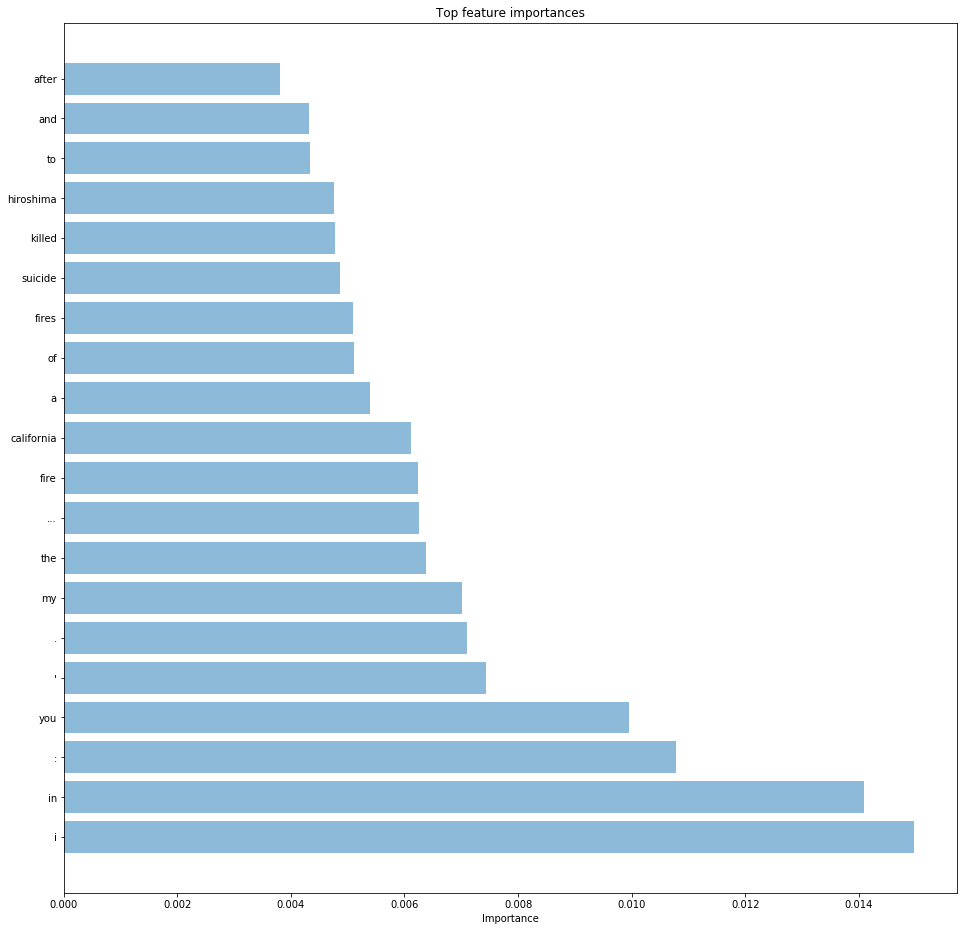

In [162]:
features = {dftrain_minimal_noprep.columns[i]:rf.feature_importances_[i] for i in range(len(rf.feature_importances_))}
top_features = sorted(features.items(), key=lambda x: x[1], reverse=True)[0:100]
topfeatures = pd.DataFrame(columns = ['feature', 'importance'])
topfeatures['feature'] = [top_features[i][0] for i in range(100)]
topfeatures['importance'] = [top_features[i][1] for i in range(100)]

plt.figure(figsize=(16,16))
plt.barh([i for i in range(20)], topfeatures['importance'][0:20], align='center', alpha=0.5)
plt.yticks([i for i in range(20)], topfeatures['feature'][0:20])
plt.xlabel('Importance')
plt.title('Top feature importances')

plt.show()

In [43]:
# Critical t value for n = 5 and 95% confidence is 2.78
# ddof=1 gives the sample standard deviation
# Assumes len(scores) = 5
def make_CI(name, scores):
    mean_score = np.mean(scores)
    ci_val = 2.78*np.std(scores, ddof=1)/np.sqrt(5)
    print('{}: {:.2f}% +/- {:.2f}%'.format(name, 100*mean_score, 100*ci_val))

def all_metrics(scores):
    make_CI('Accuracy', scores[0])
    make_CI('Precision for positive class', scores[1])
    make_CI('Precision for negative class', scores[2])
    make_CI('Recall for positive class', scores[3])
    make_CI('Recall for negative class', scores[4])
    make_CI('F for positive class', scores[5])
    make_CI('F for negative class', scores[6])
    make_CI('Mean F score', scores[7])

In [44]:
# POS tagging, raw counts
all_metrics(cross_validate_random_forest(dftrain_pos_minimal, 500))
# POS tagging, normalized
all_metrics(cross_validate_random_forest(dftrain_pos_min_norm, 500))
# Typo, woops. Don't want to rerun these

(Took 83.597 sec)
(Took 84.683 sec)
(Took 87.339 sec)
(Took 84.173 sec)
(Took 83.563 sec)
Combined confusion matrix:
[[3918.  424.]
 [1250. 2021.]]
(Overall, took 423.794 sec)
Accuracy: 78.01% +/- 0.71%
Precision for positive class: 75.82% +/- 1.75%
Precision for negative class: 82.67% +/- 2.21%
Recall for positive class: 90.25% +/- 1.23%
Recall for negative class: 61.80% +/- 2.17%
F for positive class: 82.39% +/- 0.71%
F for negative class: 70.70% +/- 1.13%
Mean F score: 76.55% +/- 0.74%
(Took 84.540 sec)
(Took 86.329 sec)
(Took 88.001 sec)
(Took 84.978 sec)
(Took 81.386 sec)
Combined confusion matrix:
[[3940.  402.]
 [1315. 1956.]]
(Overall, took 425.446 sec)
Accuracy: 77.45% +/- 1.06%
Precision for positive class: 74.98% +/- 1.96%
Precision for negative class: 82.96% +/- 1.40%
Recall for positive class: 90.74% +/- 0.94%
Recall for negative class: 59.82% +/- 2.31%
F for positive class: 82.10% +/- 1.06%
F for negative class: 69.49% +/- 1.23%
Mean F score: 75.80% +/- 1.00%


NameError: name 'dftrain_pos_min_tdidf' is not defined

In [45]:
# POS tagging, TF-IDF
all_metrics(cross_validate_random_forest(dftrain_pos_min_tfidf, 500))

(Took 81.309 sec)
(Took 78.752 sec)
(Took 85.863 sec)
(Took 83.712 sec)
(Took 84.529 sec)
Combined confusion matrix:
[[3929.  413.]
 [1311. 1960.]]
(Overall, took 414.357 sec)
Accuracy: 77.35% +/- 0.71%
Precision for positive class: 74.98% +/- 1.71%
Precision for negative class: 82.61% +/- 1.81%
Recall for positive class: 90.50% +/- 1.02%
Recall for negative class: 59.94% +/- 1.88%
F for positive class: 82.00% +/- 0.80%
F for negative class: 69.45% +/- 0.90%
Mean F score: 75.72% +/- 0.64%


In [48]:
# Bigrams, no preprocessing
all_metrics(cross_validate_random_forest(dftrain_bi_minimal, 500))

(Took 94.395 sec)
(Took 94.816 sec)
(Took 95.213 sec)
(Took 95.183 sec)
(Took 91.817 sec)
Combined confusion matrix:
[[3925.  417.]
 [1215. 2056.]]
(Overall, took 471.786 sec)
Accuracy: 78.56% +/- 0.81%
Precision for positive class: 76.36% +/- 1.67%
Precision for negative class: 83.16% +/- 1.90%
Recall for positive class: 90.40% +/- 1.34%
Recall for negative class: 62.87% +/- 1.86%
F for positive class: 82.78% +/- 0.95%
F for negative class: 71.58% +/- 0.79%
Mean F score: 77.18% +/- 0.66%


In [125]:
# Bigrams, normalized
all_metrics(cross_validate_random_forest(dftrain_bi_min_norm, 500))
# Bigrams, TF-IDF
all_metrics(cross_validate_random_forest(dftrain_bi_min_tfidf, 500))

(Took 103.832 sec)
(Took 99.711 sec)
(Took 100.042 sec)
(Took 99.642 sec)
(Took 104.247 sec)
Combined confusion matrix:
[[3934.  408.]
 [1267. 2004.]]
(Overall, took 507.804 sec)
Accuracy: 78.00% +/- 0.93%
Precision for positive class: 75.64% +/- 1.91%
Precision for negative class: 83.11% +/- 2.07%
Recall for positive class: 90.61% +/- 1.32%
Recall for negative class: 61.29% +/- 1.97%
F for positive class: 82.44% +/- 0.99%
F for negative class: 70.53% +/- 0.77%
Mean F score: 76.48% +/- 0.79%
(Took 102.143 sec)
(Took 98.834 sec)
(Took 103.584 sec)
(Took 101.021 sec)
(Took 102.712 sec)
Combined confusion matrix:
[[3929.  413.]
 [1251. 2020.]]
(Overall, took 508.609 sec)
Accuracy: 78.14% +/- 0.82%
Precision for positive class: 75.85% +/- 1.66%
Precision for negative class: 83.05% +/- 2.22%
Recall for positive class: 90.49% +/- 1.43%
Recall for negative class: 61.77% +/- 1.55%
F for positive class: 82.52% +/- 0.94%
F for negative class: 70.83% +/- 0.65%
Mean F score: 76.67% +/- 0.66%


In [35]:
# Cross-validated random forest models (all have 500 trees)
# No prep, raw counts
all_metrics(cross_validate_random_forest(dftrain_minimal_noprep, 500))
# No prep, normalized
all_metrics(cross_validate_random_forest(dftrain_min_norm_noprep, 500))
# No prep, TF-IDF
all_metrics(cross_validate_random_forest(dftrain_min_tfidf_noprep, 500))
# Preprocessed, raw counts
all_metrics(cross_validate_random_forest(dftrain_minimal, 500))
# Preprocessed, normalized
all_metrics(cross_validate_random_forest(dftrain_min_norm, 500))
# Preprocessed, TF-IDF
all_metrics(cross_validate_random_forest(dftrain_min_tfidf, 500))

(Took 175.586 sec)
(Took 166.540 sec)
(Took 178.447 sec)
(Took 172.954 sec)
(Took 175.714 sec)
Combined confusion matrix:
[[3967.  375.]
 [1252. 2019.]]
(Overall, took 870.133 sec)
Accuracy: 78.63% +/- 0.32%
Precision for positive class: 76.01% +/- 1.34%
Precision for negative class: 84.37% +/- 2.26%
Recall for positive class: 91.37% +/- 1.48%
Recall for negative class: 61.72% +/- 1.95%
F for positive class: 82.98% +/- 0.62%
F for negative class: 71.26% +/- 0.86%
Mean F score: 77.12% +/- 0.24%
(Took 167.798 sec)
(Took 161.820 sec)
(Took 176.910 sec)
(Took 177.370 sec)
(Took 168.292 sec)
Combined confusion matrix:
[[3976.  366.]
 [1284. 1987.]]
(Overall, took 852.725 sec)
Accuracy: 78.33% +/- 0.99%
Precision for positive class: 75.59% +/- 1.84%
Precision for negative class: 84.48% +/- 2.08%
Recall for positive class: 91.57% +/- 1.39%
Recall for negative class: 60.77% +/- 1.70%
F for positive class: 82.81% +/- 1.09%
F for negative class: 70.67% +/- 0.56%
Mean F score: 76.74% +/- 0.78%
(T

Other random forest models were tried before doing cross-validation, but these were not left in the file.
Adjusting the number of trees, 500 was found to work decently well.
Modifying the criterion between entropy and Gini did not produce better models.
Raising the minimum document threshold for a word decreased scores.
Overall, the best models ended up being the ones that didn't do any real preprocessing, which is kind of ironic given that I tried all these preprocessing options.

In [50]:
# Regularization did not help at all, sadly
def run_logistic(dataset, split, epochs, batch_size=32, reg='', patience=1):
    t0 = time.time()
    np.random.seed(1)
    train, test = train_test_split(dataset, test_size=split)
    train_x = np.array(train.drop('_target', axis=1))
    train_y = np.array(train['_target'])
    test_x = np.array(test.drop('_target', axis=1))
    test_y = np.array(test['_target'])
    print('Training...')
    nn = Sequential()
    if reg == '':
        nn.add(Dense(1, activation='sigmoid', input_shape=(train_x.shape[1],)))
    else:
        nn.add(Dense(1, activation='sigmoid', kernel_regularizer='l1', input_shape=(train_x.shape[1],)))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])
    es = EarlyStopping(monitor='val_loss', patience=patience)
    h = nn.fit(train_x, train_y, batch_size = batch_size, epochs=epochs, validation_data=(test_x, test_y), callbacks=[es])
    plt.plot(h.history['val_loss'])
    print('Predicting...')
    preds = 1*(nn.predict(test_x) > 0.5)
    cm = confusion_matrix(test_y, preds)
    print(cm)
    tp, fn, fp, tn = cm.ravel()
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    F = 2*precision*recall/(precision+recall)
    print('Accuracy: {:.2f}%\nPrecision: {:.2f}%\nRecall: {:.2f}%\nF: {:.2f}'.format(100*accuracy, 100*precision, 100*recall, 100*F))
    t1 = time.time()
    print('(Took {:.3f} sec)'.format(t1-t0))
    return nn

# 5-fold cross-validation, all metrics
def cross_validate_logistic(dataset, epochs, batch_size=32):
    t_0 = time.time()
    # Fixed at 5-fold cross-validation for now
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    X = np.array(dataset.drop('_target', axis=1))
    y = np.array(dataset['_target'])
    accs = []
    precs_p = []
    precs_n = []
    recs_p = []
    recs_n = []
    Fs_p = []
    Fs_n = []
    mFs = [] # Mean F score, this is the actual competition metric
    cm = np.zeros((2,2))
    for train_index, test_index in kf.split(X):
        t0 = time.time()
        train_x, test_x = X[train_index], X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        #print('Training...')
        nn = Sequential()
        nn.add(Dense(1, activation='sigmoid', input_shape=(train_x.shape[1],)))
        nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])
        es = EarlyStopping(monitor='val_loss', patience=1)
        h = nn.fit(train_x, train_y, batch_size = batch_size, epochs=epochs, validation_data=(test_x, test_y), callbacks=[es])
        #plt.plot(h.history['val_loss'])
        print('Predicting...')
        preds = 1*(nn.predict(test_x) > 0.5)
        cm_batch = confusion_matrix(test_y, preds)
        cm += np.array(cm_batch)
        tp, fn, fp, tn = cm_batch.ravel()
        acc = (tp+tn)/(tp+fn+fp+tn)
        accs.append( acc )
        prec_p = tp/(tp+fp)
        precs_p.append( prec_p )
        prec_n = tn/(tn+fn)
        precs_n.append( prec_n )
        rec_p = tp/(tp+fn)
        recs_p.append( rec_p )
        rec_n = tn/(tn+fp)
        recs_n.append( rec_n )
        F_p = 2*prec_p*rec_p/(prec_p+rec_p)
        Fs_p.append( F_p )
        F_n = 2*prec_n*rec_n/(prec_n+rec_n)
        Fs_n.append( F_n )
        mF = (F_p + F_n)/2.0
        mFs.append( mF )
        t1 = time.time()
        print('(Took {:.3f} sec)'.format(t1-t0))
    t_1 = time.time()
    print('Combined confusion matrix:')
    print(cm)
    print('(Overall, took {:.3f} sec)'.format(t_1-t_0))
    return [accs, precs_p, precs_n, recs_p, recs_n, Fs_p, Fs_n, mFs]

In [37]:
# Cross-validated logistic models (all have max epochs of 100, but early stopping if validation loss starts to increase)
# No prep, raw counts
all_metrics(cross_validate_logistic(dftrain_minimal_noprep, 100))
# No prep, normalized
all_metrics(cross_validate_logistic(dftrain_min_norm_noprep, 100))
# No prep, TF-IDF
all_metrics(cross_validate_logistic(dftrain_min_tfidf_noprep, 100))
# Preprocessed, raw counts
all_metrics(cross_validate_logistic(dftrain_minimal, 100))
# Preprocessed, normalized
all_metrics(cross_validate_logistic(dftrain_min_norm, 100))
# Preprocessed, TF-IDF
all_metrics(cross_validate_logistic(dftrain_min_tfidf, 100))

Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [==============================] - 3s 488us/sample - loss: 0.6500 - val_loss: 0.6065
Epoch 2/100
6090/6090 [==============================] - 1s 159us/sample - loss: 0.5783 - val_loss: 0.5613
Epoch 3/100
6090/6090 [==============================] - 1s 155us/sample - loss: 0.5338 - val_loss: 0.5327
Epoch 4/100
6090/6090 [==============================] - 1s 159us/sample - loss: 0.5017 - val_loss: 0.5133
Epoch 5/100
6090/6090 [==============================] - 1s 159us/sample - loss: 0.4768 - val_loss: 0.4986
Epoch 6/100
6090/6090 [==============================] - 1s 148us/sample - loss: 0.4561 - val_loss: 0.4876
Epoch 7/100
6090/6090 [==============================] - 1s 142us/sample - loss: 0.4386 - val_loss: 0.4788
Epoch 8/100
6090/6090 [==============================] - 1s 152us/sample - loss: 0.4233 - val_loss: 0.4718
Epoch 9/100
6090/6090 [==============================] - 1s 132us/sample - loss: 0.4098 - val_lo

Epoch 33/100
6090/6090 [==============================] - 1s 138us/sample - loss: 0.5174 - val_loss: 0.5390
Epoch 34/100
6090/6090 [==============================] - 1s 138us/sample - loss: 0.5143 - val_loss: 0.5367
Epoch 35/100
6090/6090 [==============================] - 1s 137us/sample - loss: 0.5113 - val_loss: 0.5344
Epoch 36/100
6090/6090 [==============================] - 1s 136us/sample - loss: 0.5083 - val_loss: 0.5322
Epoch 37/100
6090/6090 [==============================] - 1s 137us/sample - loss: 0.5054 - val_loss: 0.5301
Epoch 38/100
6090/6090 [==============================] - 1s 137us/sample - loss: 0.5026 - val_loss: 0.5281
Epoch 39/100
6090/6090 [==============================] - 1s 137us/sample - loss: 0.4999 - val_loss: 0.5261
Epoch 40/100
6090/6090 [==============================] - 1s 136us/sample - loss: 0.4972 - val_loss: 0.5242
Epoch 41/100
6090/6090 [==============================] - 1s 137us/sample - loss: 0.4945 - val_loss: 0.5224
Epoch 42/100
6090/6090 [====

Epoch 84/100
6090/6090 [==============================] - 1s 139us/sample - loss: 0.4152 - val_loss: 0.4779
Epoch 85/100
6090/6090 [==============================] - 1s 138us/sample - loss: 0.4139 - val_loss: 0.4774
Epoch 86/100
6090/6090 [==============================] - 1s 146us/sample - loss: 0.4126 - val_loss: 0.4767
Epoch 87/100
6090/6090 [==============================] - 1s 140us/sample - loss: 0.4113 - val_loss: 0.4762
Epoch 88/100
6090/6090 [==============================] - 1s 139us/sample - loss: 0.4100 - val_loss: 0.4756
Epoch 89/100
6090/6090 [==============================] - 1s 139us/sample - loss: 0.4087 - val_loss: 0.4749
Epoch 90/100
6090/6090 [==============================] - 1s 139us/sample - loss: 0.4075 - val_loss: 0.4744
Epoch 91/100
6090/6090 [==============================] - 1s 140us/sample - loss: 0.4062 - val_loss: 0.4739
Epoch 92/100
6090/6090 [==============================] - 1s 138us/sample - loss: 0.4050 - val_loss: 0.4734
Epoch 93/100
6090/6090 [====

6091/6091 [==============================] - 1s 144us/sample - loss: 0.5132 - val_loss: 0.5422
Epoch 35/100
6091/6091 [==============================] - 1s 142us/sample - loss: 0.5103 - val_loss: 0.5400
Epoch 36/100
6091/6091 [==============================] - 1s 141us/sample - loss: 0.5073 - val_loss: 0.5379
Epoch 37/100
6091/6091 [==============================] - 1s 142us/sample - loss: 0.5045 - val_loss: 0.5358
Epoch 38/100
6091/6091 [==============================] - 1s 141us/sample - loss: 0.5017 - val_loss: 0.5338
Epoch 39/100
6091/6091 [==============================] - 1s 142us/sample - loss: 0.4989 - val_loss: 0.5319
Epoch 40/100
6091/6091 [==============================] - 1s 144us/sample - loss: 0.4962 - val_loss: 0.5300
Epoch 41/100
6091/6091 [==============================] - 1s 141us/sample - loss: 0.4936 - val_loss: 0.5282
Epoch 42/100
6091/6091 [==============================] - 1s 142us/sample - loss: 0.4910 - val_loss: 0.5264
Epoch 43/100
6091/6091 [=================

Epoch 85/100
6091/6091 [==============================] - 1s 143us/sample - loss: 0.4124 - val_loss: 0.4852
Epoch 86/100
6091/6091 [==============================] - 1s 143us/sample - loss: 0.4111 - val_loss: 0.4846
Epoch 87/100
6091/6091 [==============================] - 1s 143us/sample - loss: 0.4099 - val_loss: 0.4840
Epoch 88/100
6091/6091 [==============================] - 1s 144us/sample - loss: 0.4086 - val_loss: 0.4834
Epoch 89/100
6091/6091 [==============================] - 1s 146us/sample - loss: 0.4073 - val_loss: 0.4828
Epoch 90/100
6091/6091 [==============================] - 1s 145us/sample - loss: 0.4061 - val_loss: 0.4822
Epoch 91/100
6091/6091 [==============================] - 1s 146us/sample - loss: 0.4049 - val_loss: 0.4816
Epoch 92/100
6091/6091 [==============================] - 1s 143us/sample - loss: 0.4037 - val_loss: 0.4811
Epoch 93/100
6091/6091 [==============================] - 1s 146us/sample - loss: 0.4025 - val_loss: 0.4806
Epoch 94/100
6091/6091 [====

6090/6090 [==============================] - 1s 193us/sample - loss: 0.3692 - val_loss: 0.4647
Epoch 51/100
6090/6090 [==============================] - 1s 246us/sample - loss: 0.3667 - val_loss: 0.4639
Epoch 52/100
6090/6090 [==============================] - 1s 186us/sample - loss: 0.3642 - val_loss: 0.4631
Epoch 53/100
6090/6090 [==============================] - 1s 176us/sample - loss: 0.3618 - val_loss: 0.4624
Epoch 54/100
6090/6090 [==============================] - 1s 165us/sample - loss: 0.3594 - val_loss: 0.4617
Epoch 55/100
6090/6090 [==============================] - 1s 169us/sample - loss: 0.3570 - val_loss: 0.4610
Epoch 56/100
6090/6090 [==============================] - 1s 163us/sample - loss: 0.3548 - val_loss: 0.4604
Epoch 57/100
6090/6090 [==============================] - 1s 161us/sample - loss: 0.3525 - val_loss: 0.4599
Epoch 58/100
6090/6090 [==============================] - 1s 166us/sample - loss: 0.3503 - val_loss: 0.4594
Epoch 59/100
6090/6090 [=================

6091/6091 [==============================] - 1s 137us/sample - loss: 0.4077 - val_loss: 0.4834
Epoch 38/100
6091/6091 [==============================] - 1s 137us/sample - loss: 0.4042 - val_loss: 0.4815
Epoch 39/100
6091/6091 [==============================] - 1s 138us/sample - loss: 0.4008 - val_loss: 0.4798
Epoch 40/100
6091/6091 [==============================] - 1s 138us/sample - loss: 0.3975 - val_loss: 0.4782
Epoch 41/100
6091/6091 [==============================] - 1s 137us/sample - loss: 0.3943 - val_loss: 0.4767
Epoch 42/100
6091/6091 [==============================] - 1s 138us/sample - loss: 0.3911 - val_loss: 0.4751
Epoch 43/100
6091/6091 [==============================] - 1s 138us/sample - loss: 0.3881 - val_loss: 0.4736
Epoch 44/100
6091/6091 [==============================] - 1s 139us/sample - loss: 0.3851 - val_loss: 0.4723
Epoch 45/100
6091/6091 [==============================] - 1s 138us/sample - loss: 0.3822 - val_loss: 0.4710
Epoch 46/100
6091/6091 [=================

6090/6090 [==============================] - 1s 108us/sample - loss: 0.4165 - val_loss: 0.4725
Epoch 15/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4095 - val_loss: 0.4690
Epoch 16/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4029 - val_loss: 0.4664
Epoch 17/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.3968 - val_loss: 0.4638
Epoch 18/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.3912 - val_loss: 0.4614
Epoch 19/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.3858 - val_loss: 0.4597
Epoch 20/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.3809 - val_loss: 0.4580
Epoch 21/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.3762 - val_loss: 0.4567
Epoch 22/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.3717 - val_loss: 0.4557
Epoch 23/100
6090/6090 [=================

6090/6090 [==============================] - 1s 107us/sample - loss: 0.6413 - val_loss: 0.6429
Epoch 7/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.6341 - val_loss: 0.6372
Epoch 8/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.6271 - val_loss: 0.6317
Epoch 9/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.6203 - val_loss: 0.6264
Epoch 10/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.6137 - val_loss: 0.6212
Epoch 11/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.6072 - val_loss: 0.6163
Epoch 12/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.6010 - val_loss: 0.6115
Epoch 13/100
6090/6090 [==============================] - 1s 109us/sample - loss: 0.5949 - val_loss: 0.6069
Epoch 14/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.5890 - val_loss: 0.6025
Epoch 15/100
6090/6090 [====================

6090/6090 [==============================] - 1s 113us/sample - loss: 0.3954 - val_loss: 0.4880
Epoch 83/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.3941 - val_loss: 0.4877
Epoch 84/100
6090/6090 [==============================] - 1s 111us/sample - loss: 0.3928 - val_loss: 0.4873
Epoch 85/100
6090/6090 [==============================] - 1s 113us/sample - loss: 0.3915 - val_loss: 0.4871
Epoch 86/100
6090/6090 [==============================] - 1s 111us/sample - loss: 0.3903 - val_loss: 0.4868
Epoch 87/100
6090/6090 [==============================] - 1s 112us/sample - loss: 0.3891 - val_loss: 0.4866
Epoch 88/100
6090/6090 [==============================] - 1s 112us/sample - loss: 0.3879 - val_loss: 0.4863
Epoch 89/100
6090/6090 [==============================] - 1s 111us/sample - loss: 0.3867 - val_loss: 0.4861
Epoch 90/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.3855 - val_loss: 0.4859
Epoch 91/100
6090/6090 [=================

6090/6090 [==============================] - 1s 109us/sample - loss: 0.4405 - val_loss: 0.4931
Epoch 58/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4385 - val_loss: 0.4920
Epoch 59/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4365 - val_loss: 0.4910
Epoch 60/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4346 - val_loss: 0.4900
Epoch 61/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.4326 - val_loss: 0.4891
Epoch 62/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4308 - val_loss: 0.4882
Epoch 63/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.4289 - val_loss: 0.4873
Epoch 64/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4271 - val_loss: 0.4864
Epoch 65/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4253 - val_loss: 0.4856
Epoch 66/100
6090/6090 [=================

6091/6091 [==============================] - 1s 111us/sample - loss: 0.6343 - val_loss: 0.6383
Epoch 8/100
6091/6091 [==============================] - 1s 110us/sample - loss: 0.6274 - val_loss: 0.6328
Epoch 9/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.6206 - val_loss: 0.6275
Epoch 10/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.6141 - val_loss: 0.6223
Epoch 11/100
6091/6091 [==============================] - 1s 106us/sample - loss: 0.6078 - val_loss: 0.6172
Epoch 12/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.6016 - val_loss: 0.6123
Epoch 13/100
6091/6091 [==============================] - 1s 106us/sample - loss: 0.5956 - val_loss: 0.6076
Epoch 14/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.5898 - val_loss: 0.6030
Epoch 15/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.5842 - val_loss: 0.5986
Epoch 16/100
6091/6091 [===================

Epoch 83/100
6091/6091 [==============================] - 1s 112us/sample - loss: 0.3984 - val_loss: 0.4766
Epoch 84/100
6091/6091 [==============================] - 1s 120us/sample - loss: 0.3971 - val_loss: 0.4761
Epoch 85/100
6091/6091 [==============================] - 1s 119us/sample - loss: 0.3959 - val_loss: 0.4757
Epoch 86/100
6091/6091 [==============================] - 1s 116us/sample - loss: 0.3947 - val_loss: 0.4752
Epoch 87/100
6091/6091 [==============================] - 1s 113us/sample - loss: 0.3935 - val_loss: 0.4747
Epoch 88/100
6091/6091 [==============================] - 1s 114us/sample - loss: 0.3923 - val_loss: 0.4743
Epoch 89/100
6091/6091 [==============================] - 1s 114us/sample - loss: 0.3911 - val_loss: 0.4739
Epoch 90/100
6091/6091 [==============================] - 1s 112us/sample - loss: 0.3899 - val_loss: 0.4735
Epoch 91/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.3888 - val_loss: 0.4732
Epoch 92/100
6091/6091 [====

Epoch 58/100
6091/6091 [==============================] - 1s 109us/sample - loss: 0.4351 - val_loss: 0.5048
Epoch 59/100
6091/6091 [==============================] - 1s 108us/sample - loss: 0.4331 - val_loss: 0.5038
Epoch 60/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.4311 - val_loss: 0.5028
Epoch 61/100
6091/6091 [==============================] - 1s 108us/sample - loss: 0.4292 - val_loss: 0.5019
Epoch 62/100
6091/6091 [==============================] - 1s 108us/sample - loss: 0.4274 - val_loss: 0.5010
Epoch 63/100
6091/6091 [==============================] - 1s 108us/sample - loss: 0.4255 - val_loss: 0.5001
Epoch 64/100
6091/6091 [==============================] - 1s 108us/sample - loss: 0.4237 - val_loss: 0.4993
Epoch 65/100
6091/6091 [==============================] - 1s 108us/sample - loss: 0.4219 - val_loss: 0.4985
Epoch 66/100
6091/6091 [==============================] - 1s 108us/sample - loss: 0.4202 - val_loss: 0.4977
Epoch 67/100
6091/6091 [====

6090/6090 [==============================] - 1s 109us/sample - loss: 0.5646 - val_loss: 0.5927
Epoch 9/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.5526 - val_loss: 0.5845
Epoch 10/100
6090/6090 [==============================] - 1s 109us/sample - loss: 0.5413 - val_loss: 0.5768
Epoch 11/100
6090/6090 [==============================] - 1s 109us/sample - loss: 0.5307 - val_loss: 0.5696
Epoch 12/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.5207 - val_loss: 0.5630
Epoch 13/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.5113 - val_loss: 0.5569
Epoch 14/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.5025 - val_loss: 0.5512
Epoch 15/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4941 - val_loss: 0.5460
Epoch 16/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4862 - val_loss: 0.5411
Epoch 17/100
6090/6090 [==================

In [51]:
# POS tagging
# Raw counts
all_metrics(cross_validate_logistic(dftrain_pos_minimal, 100))
# Bigram
# Raw counts
all_metrics(cross_validate_logistic(dftrain_bi_minimal, 100))

Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [==============================] - 4s 607us/sample - loss: 0.6505 - val_loss: 0.6104
Epoch 2/100
6090/6090 [==============================] - 1s 115us/sample - loss: 0.5842 - val_loss: 0.5677
Epoch 3/100
6090/6090 [==============================] - 1s 103us/sample - loss: 0.5442 - val_loss: 0.5404
Epoch 4/100
6090/6090 [==============================] - 1s 96us/sample - loss: 0.5156 - val_loss: 0.5216
Epoch 5/100
6090/6090 [==============================] - 1s 97us/sample - loss: 0.4932 - val_loss: 0.5073
Epoch 6/100
6090/6090 [==============================] - 1s 103us/sample - loss: 0.4747 - val_loss: 0.4963
Epoch 7/100
6090/6090 [==============================] - 1s 105us/sample - loss: 0.4591 - val_loss: 0.4875
Epoch 8/100
6090/6090 [==============================] - 1s 109us/sample - loss: 0.4455 - val_loss: 0.4800
Epoch 9/100
6090/6090 [==============================] - 1s 113us/sample - loss: 0.4335 - val_loss

6090/6090 [==============================] - 1s 99us/sample - loss: 0.3429 - val_loss: 0.4712
Epoch 22/100
6090/6090 [==============================] - 1s 97us/sample - loss: 0.3382 - val_loss: 0.4719
Predicting...
(Took 15.178 sec)
Train on 6091 samples, validate on 1522 samples
Epoch 1/100
6091/6091 [==============================] - 1s 131us/sample - loss: 0.6465 - val_loss: 0.6133
Epoch 2/100
6091/6091 [==============================] - 1s 97us/sample - loss: 0.5828 - val_loss: 0.5726
Epoch 3/100
6091/6091 [==============================] - 1s 95us/sample - loss: 0.5434 - val_loss: 0.5462
Epoch 4/100
6091/6091 [==============================] - 1s 99us/sample - loss: 0.5151 - val_loss: 0.5276
Epoch 5/100
6091/6091 [==============================] - 1s 94us/sample - loss: 0.4929 - val_loss: 0.5134
Epoch 6/100
6091/6091 [==============================] - 1s 93us/sample - loss: 0.4745 - val_loss: 0.5022
Epoch 7/100
6091/6091 [==============================] - 1s 94us/sample - loss: 0.

6090/6090 [==============================] - 1s 99us/sample - loss: 0.3612 - val_loss: 0.4456
Epoch 19/100
6090/6090 [==============================] - 1s 101us/sample - loss: 0.3560 - val_loss: 0.4446
Epoch 20/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.3510 - val_loss: 0.4438
Epoch 21/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.3464 - val_loss: 0.4436
Epoch 22/100
6090/6090 [==============================] - 1s 98us/sample - loss: 0.3419 - val_loss: 0.4429
Epoch 23/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.3377 - val_loss: 0.4428
Epoch 24/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.3337 - val_loss: 0.4426
Epoch 25/100
6090/6090 [==============================] - 1s 100us/sample - loss: 0.3298 - val_loss: 0.4428
Predicting...
(Took 16.847 sec)
Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [==============================] - 1s 152us/sample -

Epoch 22/100
6091/6091 [==============================] - 1s 96us/sample - loss: 0.3418 - val_loss: 0.4476
Epoch 23/100
6091/6091 [==============================] - 1s 99us/sample - loss: 0.3375 - val_loss: 0.4472
Epoch 24/100
6091/6091 [==============================] - 1s 98us/sample - loss: 0.3334 - val_loss: 0.4473
Predicting...
(Took 15.948 sec)
Train on 6091 samples, validate on 1522 samples
Epoch 1/100
6091/6091 [==============================] - 1s 145us/sample - loss: 0.6419 - val_loss: 0.6130
Epoch 2/100
6091/6091 [==============================] - 1s 104us/sample - loss: 0.5775 - val_loss: 0.5726
Epoch 3/100
6091/6091 [==============================] - 1s 98us/sample - loss: 0.5371 - val_loss: 0.5464
Epoch 4/100
6091/6091 [==============================] - 1s 102us/sample - loss: 0.5083 - val_loss: 0.5283
Epoch 5/100
6091/6091 [==============================] - 1s 104us/sample - loss: 0.4858 - val_loss: 0.5147
Epoch 6/100
6091/6091 [==============================] - 1s 101us

In [127]:
# POS tagging, transformed
# Normalized
all_metrics(cross_validate_logistic(dftrain_pos_min_norm, 100))
# TF-IDF
all_metrics(cross_validate_logistic(dftrain_pos_min_tfidf, 100))

Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [==============================] - 1s 148us/sample - loss: 0.6864 - val_loss: 0.6787
Epoch 2/100
6090/6090 [==============================] - 1s 102us/sample - loss: 0.6744 - val_loss: 0.6686
Epoch 3/100
6090/6090 [==============================] - 1s 101us/sample - loss: 0.6653 - val_loss: 0.6607
Epoch 4/100
6090/6090 [==============================] - 1s 100us/sample - loss: 0.6576 - val_loss: 0.6539
Epoch 5/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.6505 - val_loss: 0.6477
Epoch 6/100
6090/6090 [==============================] - 1s 112us/sample - loss: 0.6437 - val_loss: 0.6417
Epoch 7/100
6090/6090 [==============================] - 1s 118us/sample - loss: 0.6372 - val_loss: 0.6362
Epoch 8/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.6310 - val_loss: 0.6308
Epoch 9/100
6090/6090 [==============================] - 1s 101us/sample - loss: 0.6251 - val_lo

6090/6090 [==============================] - 1s 100us/sample - loss: 0.4452 - val_loss: 0.4894
Epoch 77/100
6090/6090 [==============================] - 1s 109us/sample - loss: 0.4438 - val_loss: 0.4887
Epoch 78/100
6090/6090 [==============================] - 1s 103us/sample - loss: 0.4425 - val_loss: 0.4879
Epoch 79/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.4412 - val_loss: 0.4871
Epoch 80/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.4399 - val_loss: 0.4864
Epoch 81/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.4386 - val_loss: 0.4857
Epoch 82/100
6090/6090 [==============================] - 1s 98us/sample - loss: 0.4373 - val_loss: 0.4851
Epoch 83/100
6090/6090 [==============================] - 1s 95us/sample - loss: 0.4361 - val_loss: 0.4843
Epoch 84/100
6090/6090 [==============================] - 1s 100us/sample - loss: 0.4349 - val_loss: 0.4837
Epoch 85/100
6090/6090 [=====================

6090/6090 [==============================] - 1s 123us/sample - loss: 0.4857 - val_loss: 0.5162
Epoch 52/100
6090/6090 [==============================] - 1s 132us/sample - loss: 0.4837 - val_loss: 0.5149
Epoch 53/100
6090/6090 [==============================] - 1s 127us/sample - loss: 0.4818 - val_loss: 0.5137
Epoch 54/100
6090/6090 [==============================] - 1s 126us/sample - loss: 0.4799 - val_loss: 0.5124
Epoch 55/100
6090/6090 [==============================] - 1s 98us/sample - loss: 0.4780 - val_loss: 0.5111
Epoch 56/100
6090/6090 [==============================] - 1s 121us/sample - loss: 0.4762 - val_loss: 0.5099
Epoch 57/100
6090/6090 [==============================] - 1s 120us/sample - loss: 0.4744 - val_loss: 0.5088
Epoch 58/100
6090/6090 [==============================] - 1s 104us/sample - loss: 0.4726 - val_loss: 0.5077
Epoch 59/100
6090/6090 [==============================] - 1s 95us/sample - loss: 0.4708 - val_loss: 0.5065
Epoch 60/100
6090/6090 [===================

6090/6090 [==============================] - 1s 96us/sample - loss: 0.5483 - val_loss: 0.5743
Epoch 27/100
6090/6090 [==============================] - 1s 96us/sample - loss: 0.5449 - val_loss: 0.5718
Epoch 28/100
6090/6090 [==============================] - 1s 95us/sample - loss: 0.5416 - val_loss: 0.5694
Epoch 29/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.5384 - val_loss: 0.5670
Epoch 30/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.5353 - val_loss: 0.5647
Epoch 31/100
6090/6090 [==============================] - 1s 102us/sample - loss: 0.5322 - val_loss: 0.5625
Epoch 32/100
6090/6090 [==============================] - 1s 103us/sample - loss: 0.5293 - val_loss: 0.5603
Epoch 33/100
6090/6090 [==============================] - 1s 103us/sample - loss: 0.5264 - val_loss: 0.5582
Epoch 34/100
6090/6090 [==============================] - 1s 100us/sample - loss: 0.5236 - val_loss: 0.5563
Epoch 35/100
6090/6090 [======================

6091/6091 [==============================] - ETA: 0s - loss: 0.686 - 1s 142us/sample - loss: 0.6855 - val_loss: 0.6789
Epoch 2/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.6737 - val_loss: 0.6695
Epoch 3/100
6091/6091 [==============================] - 1s 99us/sample - loss: 0.6648 - val_loss: 0.6621
Epoch 4/100
6091/6091 [==============================] - 1s 99us/sample - loss: 0.6571 - val_loss: 0.6555
Epoch 5/100
6091/6091 [==============================] - 1s 98us/sample - loss: 0.6501 - val_loss: 0.6494
Epoch 6/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.6433 - val_loss: 0.6435
Epoch 7/100
6091/6091 [==============================] - 1s 110us/sample - loss: 0.6369 - val_loss: 0.6380
Epoch 8/100
6091/6091 [==============================] - 1s 102us/sample - loss: 0.6307 - val_loss: 0.6327
Epoch 9/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.6248 - val_loss: 0.6276
Epoch 10/100
6091/6091 [====

Epoch 77/100
6091/6091 [==============================] - 1s 98us/sample - loss: 0.4445 - val_loss: 0.4904
Epoch 78/100
6091/6091 [==============================] - 1s 98us/sample - loss: 0.4432 - val_loss: 0.4896
Epoch 79/100
6091/6091 [==============================] - 1s 97us/sample - loss: 0.4419 - val_loss: 0.4889
Epoch 80/100
6091/6091 [==============================] - 1s 103us/sample - loss: 0.4406 - val_loss: 0.4881
Epoch 81/100
6091/6091 [==============================] - 1s 102us/sample - loss: 0.4394 - val_loss: 0.4873
Epoch 82/100
6091/6091 [==============================] - 1s 102us/sample - loss: 0.4381 - val_loss: 0.4865
Epoch 83/100
6091/6091 [==============================] - 1s 97us/sample - loss: 0.4369 - val_loss: 0.4858
Epoch 84/100
6091/6091 [==============================] - 1s 97us/sample - loss: 0.4357 - val_loss: 0.4851
Epoch 85/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.4345 - val_loss: 0.4844
Epoch 86/100
6091/6091 [=========

6091/6091 [==============================] - 1s 112us/sample - loss: 0.4820 - val_loss: 0.5235
Epoch 53/100
6091/6091 [==============================] - 1s 106us/sample - loss: 0.4801 - val_loss: 0.5222
Epoch 54/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.4782 - val_loss: 0.5210
Epoch 55/100
6091/6091 [==============================] - 1s 106us/sample - loss: 0.4764 - val_loss: 0.5198
Epoch 56/100
6091/6091 [==============================] - 1s 102us/sample - loss: 0.4746 - val_loss: 0.5186
Epoch 57/100
6091/6091 [==============================] - 1s 100us/sample - loss: 0.4728 - val_loss: 0.5175
Epoch 58/100
6091/6091 [==============================] - 1s 103us/sample - loss: 0.4710 - val_loss: 0.5163
Epoch 59/100
6091/6091 [==============================] - 1s 119us/sample - loss: 0.4693 - val_loss: 0.5153
Epoch 60/100
6091/6091 [==============================] - 1s 105us/sample - loss: 0.4676 - val_loss: 0.5142
Epoch 61/100
6091/6091 [=================

Epoch 24/100
6090/6090 [==============================] - 1s 170us/sample - loss: 0.4844 - val_loss: 0.5193
Epoch 25/100
6090/6090 [==============================] - 1s 129us/sample - loss: 0.4796 - val_loss: 0.5161
Epoch 26/100
6090/6090 [==============================] - 1s 122us/sample - loss: 0.4749 - val_loss: 0.5129
Epoch 27/100
6090/6090 [==============================] - 1s 126us/sample - loss: 0.4704 - val_loss: 0.5100
Epoch 28/100
6090/6090 [==============================] - 1s 136us/sample - loss: 0.4661 - val_loss: 0.5072
Epoch 29/100
6090/6090 [==============================] - 1s 131us/sample - loss: 0.4619 - val_loss: 0.5045
Epoch 30/100
6090/6090 [==============================] - 1s 133us/sample - loss: 0.4579 - val_loss: 0.5019
Epoch 31/100
6090/6090 [==============================] - 1s 155us/sample - loss: 0.4540 - val_loss: 0.4994
Epoch 32/100
6090/6090 [==============================] - 1s 164us/sample - loss: 0.4501 - val_loss: 0.4971
Epoch 33/100
6090/6090 [====

6090/6090 [==============================] - 1s 100us/sample - loss: 0.5871 - val_loss: 0.5931
Epoch 10/100
6090/6090 [==============================] - 1s 100us/sample - loss: 0.5779 - val_loss: 0.5860
Epoch 11/100
6090/6090 [==============================] - 1s 100us/sample - loss: 0.5693 - val_loss: 0.5794
Epoch 12/100
6090/6090 [==============================] - 1s 105us/sample - loss: 0.5610 - val_loss: 0.5730
Epoch 13/100
6090/6090 [==============================] - 1s 103us/sample - loss: 0.5531 - val_loss: 0.5670
Epoch 14/100
6090/6090 [==============================] - 1s 112us/sample - loss: 0.5455 - val_loss: 0.5615
Epoch 15/100
6090/6090 [==============================] - 1s 102us/sample - loss: 0.5383 - val_loss: 0.5562
Epoch 16/100
6090/6090 [==============================] - 1s 100us/sample - loss: 0.5313 - val_loss: 0.5511
Epoch 17/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.5247 - val_loss: 0.5462
Epoch 18/100
6090/6090 [=================

6090/6090 [==============================] - 1s 104us/sample - loss: 0.6510 - val_loss: 0.6540
Epoch 4/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.6382 - val_loss: 0.6444
Epoch 5/100
6090/6090 [==============================] - 1s 100us/sample - loss: 0.6264 - val_loss: 0.6354
Epoch 6/100
6090/6090 [==============================] - 1s 101us/sample - loss: 0.6152 - val_loss: 0.6268
Epoch 7/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.6047 - val_loss: 0.6187
Epoch 8/100
6090/6090 [==============================] - 1s 103us/sample - loss: 0.5947 - val_loss: 0.6110
Epoch 9/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.5851 - val_loss: 0.6038
Epoch 10/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.5761 - val_loss: 0.5970
Epoch 11/100
6090/6090 [==============================] - 1s 120us/sample - loss: 0.5674 - val_loss: 0.5904
Epoch 12/100
6090/6090 [========================

6090/6090 [==============================] - 1s 109us/sample - loss: 0.3444 - val_loss: 0.4735
Epoch 80/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.3431 - val_loss: 0.4734
Epoch 81/100
6090/6090 [==============================] - 1s 116us/sample - loss: 0.3417 - val_loss: 0.4734
Epoch 82/100
6090/6090 [==============================] - 1s 105us/sample - loss: 0.3404 - val_loss: 0.4732
Epoch 83/100
6090/6090 [==============================] - 1s 101us/sample - loss: 0.3391 - val_loss: 0.4732
Epoch 84/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.3378 - val_loss: 0.4732
Epoch 85/100
6090/6090 [==============================] - 1s 103us/sample - loss: 0.3366 - val_loss: 0.4732
Epoch 86/100
6090/6090 [==============================] - 1s 111us/sample - loss: 0.3353 - val_loss: 0.4732
Predicting...
(Took 57.685 sec)
Train on 6091 samples, validate on 1522 samples
Epoch 1/100
6091/6091 [==============================] - 1s 149us/sam

6091/6091 [==============================] - 1s 107us/sample - loss: 0.3650 - val_loss: 0.4552
Epoch 69/100
6091/6091 [==============================] - 1s 103us/sample - loss: 0.3634 - val_loss: 0.4547
Epoch 70/100
6091/6091 [==============================] - 1s 116us/sample - loss: 0.3619 - val_loss: 0.4542
Epoch 71/100
6091/6091 [==============================] - 1s 109us/sample - loss: 0.3603 - val_loss: 0.4537
Epoch 72/100
6091/6091 [==============================] - 1s 103us/sample - loss: 0.3588 - val_loss: 0.4532
Epoch 73/100
6091/6091 [==============================] - 1s 100us/sample - loss: 0.3573 - val_loss: 0.4527
Epoch 74/100
6091/6091 [==============================] - 1s 100us/sample - loss: 0.3559 - val_loss: 0.4523
Epoch 75/100
6091/6091 [==============================] - 1s 102us/sample - loss: 0.3544 - val_loss: 0.4519
Epoch 76/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.3530 - val_loss: 0.4515
Epoch 77/100
6091/6091 [=================

6091/6091 [==============================] - 1s 152us/sample - loss: 0.4114 - val_loss: 0.4861
Epoch 45/100
6091/6091 [==============================] - 1s 122us/sample - loss: 0.4087 - val_loss: 0.4848
Epoch 46/100
6091/6091 [==============================] - 1s 123us/sample - loss: 0.4062 - val_loss: 0.4837
Epoch 47/100
6091/6091 [==============================] - 1s 115us/sample - loss: 0.4037 - val_loss: 0.4827
Epoch 48/100
6091/6091 [==============================] - 1s 117us/sample - loss: 0.4012 - val_loss: 0.4816
Epoch 49/100
6091/6091 [==============================] - 1s 111us/sample - loss: 0.3988 - val_loss: 0.4807
Epoch 50/100
6091/6091 [==============================] - 1s 105us/sample - loss: 0.3965 - val_loss: 0.4797
Epoch 51/100
6091/6091 [==============================] - 1s 108us/sample - loss: 0.3942 - val_loss: 0.4788
Epoch 52/100
6091/6091 [==============================] - 1s 106us/sample - loss: 0.3919 - val_loss: 0.4779
Epoch 53/100
6091/6091 [=================

In [128]:
# Bigrams, transformed
# Normalized
all_metrics(cross_validate_logistic(dftrain_bi_min_norm, 100))
# TF-IDF
all_metrics(cross_validate_logistic(dftrain_bi_min_tfidf, 100))

Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [==============================] - 1s 154us/sample - loss: 0.6857 - val_loss: 0.6779
Epoch 2/100
6090/6090 [==============================] - 1s 109us/sample - loss: 0.6737 - val_loss: 0.6679
Epoch 3/100
6090/6090 [==============================] - 1s 109us/sample - loss: 0.6646 - val_loss: 0.6598
Epoch 4/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.6568 - val_loss: 0.6527
Epoch 5/100
6090/6090 [==============================] - 1s 115us/sample - loss: 0.6494 - val_loss: 0.6462
Epoch 6/100
6090/6090 [==============================] - 1s 116us/sample - loss: 0.6425 - val_loss: 0.6401
Epoch 7/100
6090/6090 [==============================] - 1s 113us/sample - loss: 0.6358 - val_loss: 0.6342
Epoch 8/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.6294 - val_loss: 0.6286
Epoch 9/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.6232 - val_lo

6090/6090 [==============================] - 1s 105us/sample - loss: 0.4383 - val_loss: 0.4824
Epoch 77/100
6090/6090 [==============================] - 1s 109us/sample - loss: 0.4369 - val_loss: 0.4816
Epoch 78/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4356 - val_loss: 0.4809
Epoch 79/100
6090/6090 [==============================] - 1s 101us/sample - loss: 0.4344 - val_loss: 0.4802
Epoch 80/100
6090/6090 [==============================] - 1s 103us/sample - loss: 0.4331 - val_loss: 0.4795
Epoch 81/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4319 - val_loss: 0.4789
Epoch 82/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.4306 - val_loss: 0.4782
Epoch 83/100
6090/6090 [==============================] - 1s 104us/sample - loss: 0.4294 - val_loss: 0.4776
Epoch 84/100
6090/6090 [==============================] - 1s 116us/sample - loss: 0.4282 - val_loss: 0.4770
Epoch 85/100
6090/6090 [=================

6090/6090 [==============================] - 1s 112us/sample - loss: 0.4783 - val_loss: 0.5086
Epoch 52/100
6090/6090 [==============================] - 1s 117us/sample - loss: 0.4763 - val_loss: 0.5073
Epoch 53/100
6090/6090 [==============================] - 1s 117us/sample - loss: 0.4744 - val_loss: 0.5061
Epoch 54/100
6090/6090 [==============================] - 1s 109us/sample - loss: 0.4725 - val_loss: 0.5048
Epoch 55/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.4707 - val_loss: 0.5036
Epoch 56/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.4689 - val_loss: 0.5025
Epoch 57/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.4671 - val_loss: 0.5014
Epoch 58/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.4653 - val_loss: 0.5004
Epoch 59/100
6090/6090 [==============================] - 1s 104us/sample - loss: 0.4636 - val_loss: 0.4992
Epoch 60/100
6090/6090 [=================

6090/6090 [==============================] - 1s 100us/sample - loss: 0.5424 - val_loss: 0.5664
Epoch 27/100
6090/6090 [==============================] - 1s 98us/sample - loss: 0.5390 - val_loss: 0.5637
Epoch 28/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.5355 - val_loss: 0.5612
Epoch 29/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.5322 - val_loss: 0.5586
Epoch 30/100
6090/6090 [==============================] - 1s 102us/sample - loss: 0.5290 - val_loss: 0.5562
Epoch 31/100
6090/6090 [==============================] - 1s 114us/sample - loss: 0.5258 - val_loss: 0.5539
Epoch 32/100
6090/6090 [==============================] - 1s 103us/sample - loss: 0.5227 - val_loss: 0.5516
Epoch 33/100
6090/6090 [==============================] - 1s 98us/sample - loss: 0.5197 - val_loss: 0.5494
Epoch 34/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.5168 - val_loss: 0.5472
Epoch 35/100
6090/6090 [=====================

6091/6091 [==============================] - 1s 146us/sample - loss: 0.6856 - val_loss: 0.6786
Epoch 2/100
6091/6091 [==============================] - 1s 99us/sample - loss: 0.6732 - val_loss: 0.6690
Epoch 3/100
6091/6091 [==============================] - 1s 104us/sample - loss: 0.6640 - val_loss: 0.6614
Epoch 4/100
6091/6091 [==============================] - 1s 104us/sample - loss: 0.6561 - val_loss: 0.6547
Epoch 5/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.6488 - val_loss: 0.6485
Epoch 6/100
6091/6091 [==============================] - 1s 98us/sample - loss: 0.6419 - val_loss: 0.6425
Epoch 7/100
6091/6091 [==============================] - 1s 99us/sample - loss: 0.6352 - val_loss: 0.6368
Epoch 8/100
6091/6091 [==============================] - 1s 99us/sample - loss: 0.6288 - val_loss: 0.6313
Epoch 9/100
6091/6091 [==============================] - 1s 99us/sample - loss: 0.6226 - val_loss: 0.6261
Epoch 10/100
6091/6091 [==============================

6091/6091 [==============================] - 1s 133us/sample - loss: 0.4377 - val_loss: 0.4844
Epoch 78/100
6091/6091 [==============================] - 1s 134us/sample - loss: 0.4365 - val_loss: 0.4836
Epoch 79/100
6091/6091 [==============================] - 1s 112us/sample - loss: 0.4352 - val_loss: 0.4829
Epoch 80/100
6091/6091 [==============================] - 1s 142us/sample - loss: 0.4339 - val_loss: 0.4822
Epoch 81/100
6091/6091 [==============================] - 1s 109us/sample - loss: 0.4327 - val_loss: 0.4814
Epoch 82/100
6091/6091 [==============================] - 1s 119us/sample - loss: 0.4315 - val_loss: 0.4807
Epoch 83/100
6091/6091 [==============================] - 1s 112us/sample - loss: 0.4303 - val_loss: 0.4799
Epoch 84/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.4291 - val_loss: 0.4792
Epoch 85/100
6091/6091 [==============================] - 1s 131us/sample - loss: 0.4280 - val_loss: 0.4786
Epoch 86/100
6091/6091 [=================

6091/6091 [==============================] - 1s 143us/sample - loss: 0.4740 - val_loss: 0.5174
Epoch 53/100
6091/6091 [==============================] - 1s 146us/sample - loss: 0.4720 - val_loss: 0.5161
Epoch 54/100
6091/6091 [==============================] - 1s 141us/sample - loss: 0.4701 - val_loss: 0.5149
Epoch 55/100
6091/6091 [==============================] - 1s 118us/sample - loss: 0.4683 - val_loss: 0.5137
Epoch 56/100
6091/6091 [==============================] - 1s 118us/sample - loss: 0.4665 - val_loss: 0.5126
Epoch 57/100
6091/6091 [==============================] - 1s 116us/sample - loss: 0.4648 - val_loss: 0.5115
Epoch 58/100
6091/6091 [==============================] - 1s 121us/sample - loss: 0.4630 - val_loss: 0.5104
Epoch 59/100
6091/6091 [==============================] - 1s 120us/sample - loss: 0.4613 - val_loss: 0.5093
Epoch 60/100
6091/6091 [==============================] - 1s 122us/sample - loss: 0.4596 - val_loss: 0.5083
Epoch 61/100
6091/6091 [=================

6090/6090 [==============================] - 1s 103us/sample - loss: 0.4833 - val_loss: 0.5164
Epoch 24/100
6090/6090 [==============================] - 1s 101us/sample - loss: 0.4783 - val_loss: 0.5130
Epoch 25/100
6090/6090 [==============================] - 1s 102us/sample - loss: 0.4735 - val_loss: 0.5098
Epoch 26/100
6090/6090 [==============================] - 1s 100us/sample - loss: 0.4689 - val_loss: 0.5068
Epoch 27/100
6090/6090 [==============================] - 1s 99us/sample - loss: 0.4645 - val_loss: 0.5039
Epoch 28/100
6090/6090 [==============================] - 1s 105us/sample - loss: 0.4602 - val_loss: 0.5012
Epoch 29/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4561 - val_loss: 0.4986
Epoch 30/100
6090/6090 [==============================] - 1s 100us/sample - loss: 0.4521 - val_loss: 0.4961
Epoch 31/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.4482 - val_loss: 0.4937
Epoch 32/100
6090/6090 [==================

6090/6090 [==============================] - 1s 122us/sample - loss: 0.5185 - val_loss: 0.5396
Epoch 18/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.5121 - val_loss: 0.5350
Epoch 19/100
6090/6090 [==============================] - 1s 112us/sample - loss: 0.5059 - val_loss: 0.5306
Epoch 20/100
6090/6090 [==============================] - 1s 134us/sample - loss: 0.5000 - val_loss: 0.5265
Epoch 21/100
6090/6090 [==============================] - 1s 105us/sample - loss: 0.4944 - val_loss: 0.5226
Epoch 22/100
6090/6090 [==============================] - 1s 130us/sample - loss: 0.4890 - val_loss: 0.5188
Epoch 23/100
6090/6090 [==============================] - 1s 118us/sample - loss: 0.4838 - val_loss: 0.5154
Epoch 24/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.4788 - val_loss: 0.5121
Epoch 25/100
6090/6090 [==============================] - 1s 123us/sample - loss: 0.4740 - val_loss: 0.5089
Epoch 26/100
6090/6090 [=================

6090/6090 [==============================] - 1s 105us/sample - loss: 0.5624 - val_loss: 0.5836
Epoch 12/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.5540 - val_loss: 0.5772
Epoch 13/100
6090/6090 [==============================] - 1s 105us/sample - loss: 0.5459 - val_loss: 0.5711
Epoch 14/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.5382 - val_loss: 0.5655
Epoch 15/100
6090/6090 [==============================] - 1s 111us/sample - loss: 0.5309 - val_loss: 0.5599
Epoch 16/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.5239 - val_loss: 0.5547
Epoch 17/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.5171 - val_loss: 0.5499
Epoch 18/100
6090/6090 [==============================] - 1s 109us/sample - loss: 0.5108 - val_loss: 0.5453
Epoch 19/100
6090/6090 [==============================] - 1s 105us/sample - loss: 0.5046 - val_loss: 0.5410
Epoch 20/100
6090/6090 [=================

6091/6091 [==============================] - 1s 166us/sample - loss: 0.6832 - val_loss: 0.6741
Epoch 2/100
6091/6091 [==============================] - 1s 117us/sample - loss: 0.6648 - val_loss: 0.6600
Epoch 3/100
6091/6091 [==============================] - 1s 106us/sample - loss: 0.6497 - val_loss: 0.6480
Epoch 4/100
6091/6091 [==============================] - 1s 107us/sample - loss: 0.6363 - val_loss: 0.6373
Epoch 5/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.6239 - val_loss: 0.6273
Epoch 6/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.6123 - val_loss: 0.6181
Epoch 7/100
6091/6091 [==============================] - 1s 104us/sample - loss: 0.6013 - val_loss: 0.6094
Epoch 8/100
6091/6091 [==============================] - 1s 103us/sample - loss: 0.5910 - val_loss: 0.6012
Epoch 9/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.5811 - val_loss: 0.5935
Epoch 10/100
6091/6091 [=========================

6091/6091 [==============================] - 1s 102us/sample - loss: 0.3502 - val_loss: 0.4506
Epoch 78/100
6091/6091 [==============================] - 1s 102us/sample - loss: 0.3489 - val_loss: 0.4504
Epoch 79/100
6091/6091 [==============================] - 1s 99us/sample - loss: 0.3477 - val_loss: 0.4502
Epoch 80/100
6091/6091 [==============================] - 1s 103us/sample - loss: 0.3464 - val_loss: 0.4500
Epoch 81/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.3452 - val_loss: 0.4498
Epoch 82/100
6091/6091 [==============================] - 1s 106us/sample - loss: 0.3440 - val_loss: 0.4496
Epoch 83/100
6091/6091 [==============================] - 1s 100us/sample - loss: 0.3428 - val_loss: 0.4495
Epoch 84/100
6091/6091 [==============================] - 1s 102us/sample - loss: 0.3416 - val_loss: 0.4493
Epoch 85/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.3405 - val_loss: 0.4491
Epoch 86/100
6091/6091 [==================

6091/6091 [==============================] - 1s 104us/sample - loss: 0.3759 - val_loss: 0.4708
Epoch 59/100
6091/6091 [==============================] - 1s 103us/sample - loss: 0.3741 - val_loss: 0.4704
Epoch 60/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.3723 - val_loss: 0.4700
Epoch 61/100
6091/6091 [==============================] - 1s 103us/sample - loss: 0.3706 - val_loss: 0.4696
Epoch 62/100
6091/6091 [==============================] - 1s 112us/sample - loss: 0.3689 - val_loss: 0.4692
Epoch 63/100
6091/6091 [==============================] - 1s 100us/sample - loss: 0.3672 - val_loss: 0.4689
Epoch 64/100
6091/6091 [==============================] - 1s 104us/sample - loss: 0.3655 - val_loss: 0.4686
Epoch 65/100
6091/6091 [==============================] - 1s 104us/sample - loss: 0.3639 - val_loss: 0.4683
Epoch 66/100
6091/6091 [==============================] - 1s 101us/sample - loss: 0.3623 - val_loss: 0.4680
Epoch 67/100
6091/6091 [=================

Other logistic regression models were tried, without significant improvement.
Again, raising the document frequency threshold decreased scores.
Regularization (both L1 and L2 were tried) did not seem to improve scores at all.

No prep, raw counts
Training...
Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [==============================] - 2s 263us/sample - loss: 0.6479 - val_loss: 0.6052
Epoch 2/100
6090/6090 [==============================] - 1s 135us/sample - loss: 0.5776 - val_loss: 0.5608
Epoch 3/100
6090/6090 [==============================] - 1s 137us/sample - loss: 0.5337 - val_loss: 0.5324
Epoch 4/100
6090/6090 [==============================] - 1s 132us/sample - loss: 0.5017 - val_loss: 0.5132
Epoch 5/100
6090/6090 [==============================] - 1s 148us/sample - loss: 0.4769 - val_loss: 0.4984
Epoch 6/100
6090/6090 [==============================] - 1s 162us/sample - loss: 0.4563 - val_loss: 0.4871
Epoch 7/100
6090/6090 [==============================] - 1s 142us/sample - loss: 0.4387 - val_loss: 0.4785
Epoch 8/100
6090/6090 [==============================] - 1s 136us/sample - loss: 0.4235 - val_loss: 0.4714
Epoch 9/100
6090/6090 [==============================] - 1s 136u

6090/6090 [==============================] - 1s 153us/sample - loss: 0.4653 - val_loss: 0.5123
Epoch 25/100
6090/6090 [==============================] - 1s 173us/sample - loss: 0.4600 - val_loss: 0.5089
Epoch 26/100
6090/6090 [==============================] - 1s 139us/sample - loss: 0.4549 - val_loss: 0.5058
Epoch 27/100
6090/6090 [==============================] - 1s 137us/sample - loss: 0.4500 - val_loss: 0.5028
Epoch 28/100
6090/6090 [==============================] - 1s 139us/sample - loss: 0.4452 - val_loss: 0.5000
Epoch 29/100
6090/6090 [==============================] - 1s 139us/sample - loss: 0.4406 - val_loss: 0.4973
Epoch 30/100
6090/6090 [==============================] - 1s 157us/sample - loss: 0.4361 - val_loss: 0.4947
Epoch 31/100
6090/6090 [==============================] - 1s 148us/sample - loss: 0.4318 - val_loss: 0.4923
Epoch 32/100
6090/6090 [==============================] - 1s 151us/sample - loss: 0.4275 - val_loss: 0.4900
Epoch 33/100
6090/6090 [=================

6090/6090 [==============================] - 1s 111us/sample - loss: 0.4303 - val_loss: 0.5004
Epoch 61/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4284 - val_loss: 0.4996
Epoch 62/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.4264 - val_loss: 0.4988
Epoch 63/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4246 - val_loss: 0.4980
Epoch 64/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4228 - val_loss: 0.4973
Epoch 65/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4210 - val_loss: 0.4965
Epoch 66/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4192 - val_loss: 0.4958
Epoch 67/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.4175 - val_loss: 0.4952
Epoch 68/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4158 - val_loss: 0.4945
Epoch 69/100
6090/6090 [=================

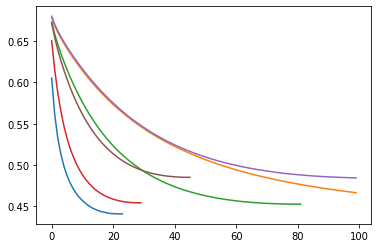

In [228]:
# No preprocessing
# Raw counts
print('No prep, raw counts')
run_logistic(dftrain_minimal_noprep, 0.2, 100)
# Normalized
print('No prep, normalized')
run_logistic(dftrain_min_norm_noprep, 0.2, 100)
# TF-IDF
print('No prep, TF-IDF')
run_logistic(dftrain_min_tfidf_noprep, 0.2, 100)
# With preprocessing
# Raw counts
print('Preprocessed, raw counts')
run_logistic(dftrain_minimal, 0.2, 100)
# Normalized
print('Preprocessed, normalized')
run_logistic(dftrain_min_norm, 0.2, 100)
# TF-IDF
print('Preprocessed, TF-IDF')
run_logistic(dftrain_min_tfidf, 0.2, 100)
print('Done with Logistic models')

Training...
Train on 7536 samples, validate on 77 samples
Epoch 1/100
7536/7536 [==============================] - 1s 131us/sample - loss: 0.6654 - val_loss: 0.6375
Epoch 2/100
7536/7536 [==============================] - 1s 91us/sample - loss: 0.6114 - val_loss: 0.5993
Epoch 3/100
7536/7536 [==============================] - 1s 95us/sample - loss: 0.5705 - val_loss: 0.5703
Epoch 4/100
7536/7536 [==============================] - 1s 111us/sample - loss: 0.5391 - val_loss: 0.5487
Epoch 5/100
7536/7536 [==============================] - 1s 110us/sample - loss: 0.5141 - val_loss: 0.5320
Epoch 6/100
7536/7536 [==============================] - 1s 93us/sample - loss: 0.4936 - val_loss: 0.5184
Epoch 7/100
7536/7536 [==============================] - 1s 102us/sample - loss: 0.4766 - val_loss: 0.5079
Epoch 8/100
7536/7536 [==============================] - 1s 101us/sample - loss: 0.4621 - val_loss: 0.4997
Epoch 9/100
7536/7536 [==============================] - 1s 102us/sample - loss: 0.4496 -

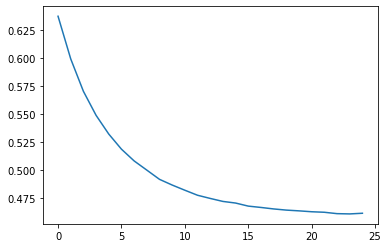

In [174]:
# Test to see feature importances
nn_test = run_logistic(dftrain_minimal, 0.01, 100)

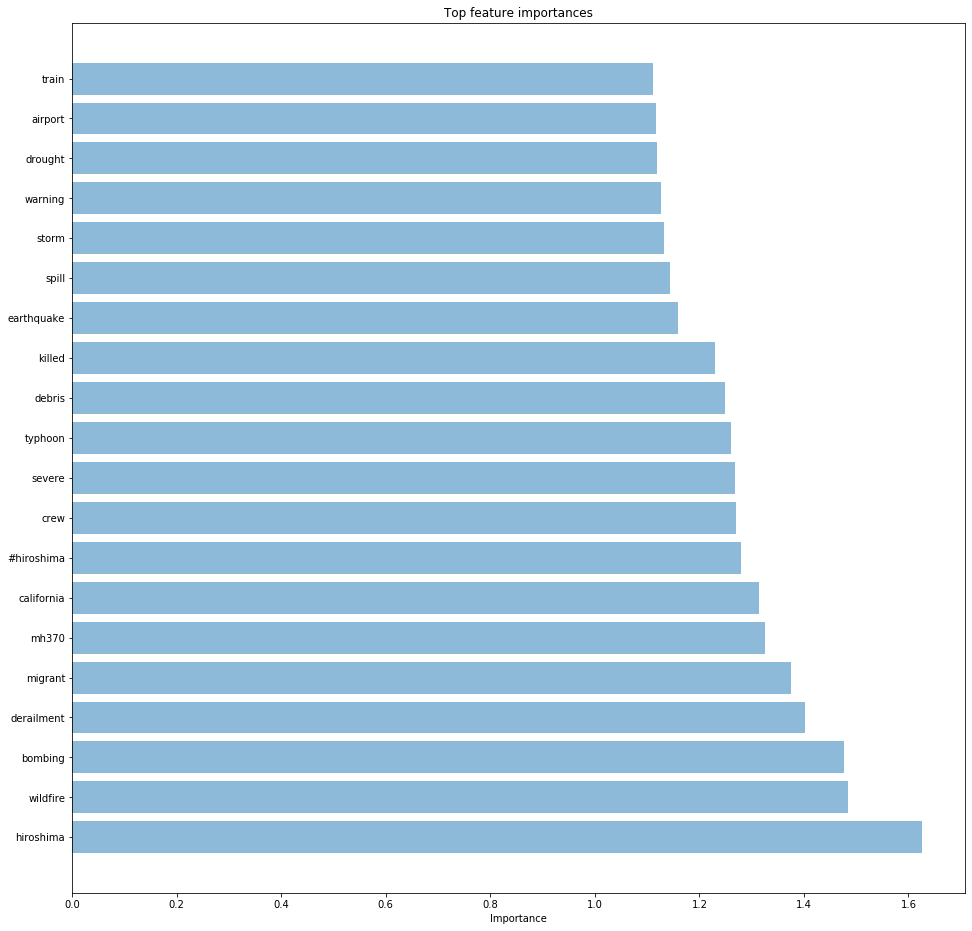

In [178]:
# Regularization may not help that much
weights = nn_test.get_weights()[0]

features = {dftrain_minimal.columns[i]:weights[i][0] for i in range(len(weights))}
top_features = sorted(features.items(), key=lambda x: x[1], reverse=True)[0:100]
topfeatures = pd.DataFrame(columns = ['feature', 'importance'])
topfeatures['feature'] = [top_features[i][0] for i in range(100)]
topfeatures['importance'] = [top_features[i][1] for i in range(100)]

plt.figure(figsize=(16,16))
plt.barh([i for i in range(20)], topfeatures['importance'][0:20], align='center', alpha=0.5)
plt.yticks([i for i in range(20)], topfeatures['feature'][0:20])
plt.xlabel('Importance')
plt.title('Top feature importances')

plt.show()

Neural networks were additional layers did not seem to produce any improvements. Several different numbers of hidden layers, and number of nodes on each hidden layer, were tried. The activation functions were varied between sigmoid and relu without any improvements. Adding dropout helped to avoid overfitting to some extent, but the resulting models were about the same as logistic regression. Better to go with the simpler model, if there isn't a significant improvement.

In [123]:
def run_neuralNet(dataset, split, epochs, batch_size=32, patience=5):
    t0 = time.time()
    np.random.seed(1)
    train, test = train_test_split(dataset, test_size=split)
    train_x = np.array(train.drop('_target', axis=1))
    train_y = np.array(train['_target'])
    test_x = np.array(test.drop('_target', axis=1))
    test_y = np.array(test['_target'])
    print('Training...')
    nn = Sequential()
    nn.add(Dense(16, activation='sigmoid', input_shape=(train_x.shape[1],)))
    nn.add(Dropout(0.5))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])
    es = EarlyStopping(monitor='val_loss', patience=patience)
    h = nn.fit(train_x, train_y, batch_size = batch_size, epochs=epochs, validation_data=(test_x, test_y), callbacks=[es])
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    print('Predicting...')
    preds = 1*(nn.predict(test_x) > 0.5)
    cm = confusion_matrix(test_y, preds)
    print(cm)
    tp, fn, fp, tn = cm.ravel()
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    F = 2*precision*recall/(precision+recall)
    print('Accuracy: {:.2f}%\nPrecision: {:.2f}%\nRecall: {:.2f}%\nF: {:.2f}'.format(100*accuracy, 100*precision, 100*recall, 100*F))
    t1 = time.time()
    print('(Took {:.3f} sec)'.format(t1-t0))
    return nn

No preprocessing, raw counts
Training...
Train on 6090 samples, validate on 1523 samples
Epoch 1/50
6090/6090 [==============================] - 1s 160us/sample - loss: 0.7309 - val_loss: 0.6493
Epoch 2/50
6090/6090 [==============================] - 1s 116us/sample - loss: 0.6786 - val_loss: 0.6253
Epoch 3/50
6090/6090 [==============================] - 1s 110us/sample - loss: 0.6486 - val_loss: 0.6032
Epoch 4/50
6090/6090 [==============================] - 1s 110us/sample - loss: 0.6168 - val_loss: 0.5814
Epoch 5/50
6090/6090 [==============================] - 1s 120us/sample - loss: 0.5842 - val_loss: 0.5584
Epoch 6/50
6090/6090 [==============================] - 1s 118us/sample - loss: 0.5690 - val_loss: 0.5365
Epoch 7/50
6090/6090 [==============================] - 1s 110us/sample - loss: 0.5522 - val_loss: 0.5194
Epoch 8/50
6090/6090 [==============================] - 1s 105us/sample - loss: 0.5210 - val_loss: 0.5017
Epoch 9/50
6090/6090 [==============================] - 1s 107u

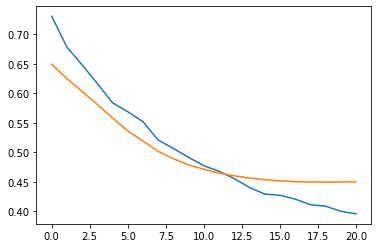

In [124]:
# Neural net models
# Only with preprocessing, otherwise there are too many weights
# Raw counts
print('No preprocessing, raw counts')
run_neuralNet(dftrain_minimal, 0.2, 50, patience=2)
# Normalized
#print('Preprocessed, normalized')
#run_neuralNet(dftrain_min_norm, 0.2, 20)
# TF-IDF
#print('Preprocessed, TF-IDF')
#run_neuralNet(dftrain_min_tfidf, 0.2, 20)
#print('Done with Neural Net models')

Some of the best models were trained on the full train data, and used to make predictions which were submitted to Kaggle. The best model submission ended up being the simple logistic regression model with no preprocessing (other than removing words that only occur in one document and that don't occur in both the train and test data). The final F score was 0.8098. This is significantly lower than the cross-validated result, and that indicates that the testing data is somewhat different in distribution than the training data. This can be expected, given the amount of variation there is in natural language.

In [39]:
# Make submission file

In [130]:
submission = pd.DataFrame(test['id'], columns=['id', 'target'])

In [40]:
def make_random_forest_predictions(trees, train, test):
    print('Training...')
    rft = RandomForestClassifier(n_estimators=trees)
    rft.fit(train.drop('_target', axis=1), train['_target'])
    print('Predicting...')
    preds = rft.predict(test)
    return preds

In [49]:
submission['target'] = make_random_forest_predictions(500, dftrain_minimal_noprep, dftest_minimal_noprep)

Training...
Predicting...


In [50]:
submission.to_csv('submission_rf_noprep.csv', index=False)
# Score: 79.55%

In [51]:
submission['target'] = make_random_forest_predictions(500, dftrain_min_tfidf, dftest_min_tfidf)

Training...
Predicting...


In [52]:
submission.to_csv('submission_rf_prep.csv', index=False)
# Score: 78.732%

In [131]:
def make_logistic_predictions(epochs, batch_size, train, test):
    print('Training...')
    nn = Sequential()
    nn.add(Dense(1, activation='sigmoid', input_shape=(train.drop('_target', axis=1).shape[1],)))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])
    nn.fit(np.array(train.drop('_target', axis=1)), np.array(train['_target']), batch_size = batch_size, epochs=epochs)
    print('Predicting...')
    preds = 1*(nn.predict(np.array(test)) > 0.5)
    return preds

In [57]:
submission['target'] = make_logistic_predictions(23, 32, dftrain_minimal_noprep, dftest_minimal_noprep)

Training...
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 172us/sample - loss: 0.6369
Epoch 2/23
7613/7613 [==============================] - 1s 129us/sample - loss: 0.5614
Epoch 3/23
7613/7613 [==============================] - 1s 121us/sample - loss: 0.5168
Epoch 4/23
7613/7613 [==============================] - 1s 116us/sample - loss: 0.4853
Epoch 5/23
7613/7613 [==============================] - 1s 107us/sample - loss: 0.4610
Epoch 6/23
7613/7613 [==============================] - 1s 104us/sample - loss: 0.4410
Epoch 7/23
7613/7613 [==============================] - 1s 107us/sample - loss: 0.4244
Epoch 8/23
7613/7613 [==============================] - 1s 114us/sample - loss: 0.4100
Epoch 9/23
7613/7613 [==============================] - 1s 108us/sample - loss: 0.3972
Epoch 10/23
7613/7613 [==============================] - 1s 109us/sample - loss: 0.3858
Epoch 11/23
7613/7613 [==============================] - 1s 110us/sample - loss: 0.3756
Epoch 1

In [58]:
submission.to_csv('submission_lg_noprep.csv', index=False)
# Score: 80.98%

In [59]:
submission['target'] = make_logistic_predictions(46, 32, dftrain_min_tfidf, dftest_min_tfidf)

Training...
Train on 7613 samples
Epoch 1/46
7613/7613 [==============================] - 1s 135us/sample - loss: 0.6800
Epoch 2/46
7613/7613 [==============================] - 1s 93us/sample - loss: 0.6537
Epoch 3/46
7613/7613 [==============================] - 1s 92us/sample - loss: 0.6320
Epoch 4/46
7613/7613 [==============================] - 1s 95us/sample - loss: 0.6128
Epoch 5/46
7613/7613 [==============================] - 1s 98us/sample - loss: 0.5952
Epoch 6/46
7613/7613 [==============================] - 1s 85us/sample - loss: 0.5791
Epoch 7/46
7613/7613 [==============================] - 1s 78us/sample - loss: 0.5643
Epoch 8/46
7613/7613 [==============================] - 1s 91us/sample - loss: 0.5506
Epoch 9/46
7613/7613 [==============================] - 1s 109us/sample - loss: 0.5379
Epoch 10/46
7613/7613 [==============================] - 1s 123us/sample - loss: 0.5261
Epoch 11/46
7613/7613 [==============================] - 1s 91us/sample - loss: 0.5153
Epoch 12/46
761

In [60]:
submission.to_csv('submission_lg_prep.csv', index=False)
# Score: 78.22%

In [ ]:
# Logistic regression, with bigrams, no preprocessing

In [132]:
submission['target'] = make_logistic_predictions(27, 32, dftrain_bi_minimal, dftest_bi_minimal)

Training...
Train on 7613 samples
Epoch 1/27
7613/7613 [==============================] - 1s 131us/sample - loss: 0.6371
Epoch 2/27
7613/7613 [==============================] - 1s 89us/sample - loss: 0.5661
Epoch 3/27
7613/7613 [==============================] - 1s 87us/sample - loss: 0.5247
Epoch 4/27
7613/7613 [==============================] - 1s 86us/sample - loss: 0.4959
Epoch 5/27
7613/7613 [==============================] - 1s 92us/sample - loss: 0.4739
Epoch 6/27
7613/7613 [==============================] - 1s 92us/sample - loss: 0.4563
Epoch 7/27
7613/7613 [==============================] - 1s 95us/sample - loss: 0.4414
Epoch 8/27
7613/7613 [==============================] - 1s 94us/sample - loss: 0.4288
Epoch 9/27
7613/7613 [==============================] - 1s 92us/sample - loss: 0.4177
Epoch 10/27
7613/7613 [==============================] - 1s 94us/sample - loss: 0.4080
Epoch 11/27
7613/7613 [==============================] - 1s 98us/sample - loss: 0.3992
Epoch 12/27
7613/

In [133]:
submission.to_csv('submission_lg_bigrams.csv', index=False)
# Score: 79.55%

A final consideration was made to ensemble together a set of logistic regression models, with some boosting of incorrectly predicted samples. First, I did this without the document frequency threshold by accident, and the result was actually higher than when I used a document frequency threshold of 1 like I usually did. However, both final results were lower in score than the plain logistic regression model.

In [134]:
def train_model(train_x, train_y, batch_size, epochs):
    nn = Sequential()
    nn.add(Dense(1, activation='sigmoid', input_shape=(train_x.shape[1],)))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])
    nn.fit(train_x, train_y, batch_size = batch_size, epochs=epochs)
    return nn

def train_ensemble(n, batch_size, epochs, data_x, data_y):
    #with tf.device('/GPU:0'):
    models = []
    total = data_x.shape[0]
    all_inds = np.arange(data_x.shape[0])
    dist = np.repeat(1, data_x.shape[0])
    for i in range(n):
        train_x = []
        train_y = []
        if i == 0:
            # First run uses all samples
            train_x = data_x
            train_y = data_y
        else:
            # Next runs weight samples more if they came up as errors
            inds = np.random.choice(all_inds, data_x.shape[0], replace=False, p=dist/total)
            train_x = data_x[inds]
            train_y = data_y[inds]
        print('Training model', i)
        # Todo: simple model for debug...
        model = train_model(train_x, train_y, batch_size, epochs)
        print('Making predictions')
        raw_pred = model.predict(train_x) # Batch size has to match for this to work, apparently.
        #print(raw_pred[0:10])
        pred = np.argmax(raw_pred, axis=1)
        #print(pred[0:10])
        errors = np.not_equal(pred, train_y)
        #print(train_y[0:10])
        #print('Model {0} accuracy is {1:.3f}'.format(i, 100*(1-np.sum(errors)/train_y.shape[0])))
        dist += errors
        total += sum(errors)
        models.append(model)
    return models

In [135]:
models = train_ensemble(25, 32, 23, np.array(dftrain_minimal.drop('_target', axis=1)), np.array(dftrain_minimal['_target']))

Training model 0
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 126us/sample - loss: 0.6635
Epoch 2/23
7613/7613 [==============================] - 1s 88us/sample - loss: 0.6094
Epoch 3/23
7613/7613 [==============================] - 1s 90us/sample - loss: 0.5689
Epoch 4/23
7613/7613 [==============================] - 1s 87us/sample - loss: 0.5376
Epoch 5/23
7613/7613 [==============================] - 1s 81us/sample - loss: 0.5127
Epoch 6/23
7613/7613 [==============================] - 1s 87us/sample - loss: 0.4924
Epoch 7/23
7613/7613 [==============================] - 1s 87us/sample - loss: 0.4757
Epoch 8/23
7613/7613 [==============================] - 1s 85us/sample - loss: 0.4613
Epoch 9/23
7613/7613 [==============================] - 1s 86us/sample - loss: 0.4489
Epoch 10/23
7613/7613 [==============================] - 1s 87us/sample - loss: 0.4382
Epoch 11/23
7613/7613 [==============================] - 1s 95us/sample - loss: 0.4287
Epoch 12/23


Making predictions
Training model 4
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 108us/sample - loss: 0.6661
Epoch 2/23
7613/7613 [==============================] - 1s 75us/sample - loss: 0.6115
Epoch 3/23
7613/7613 [==============================] - 1s 77us/sample - loss: 0.5706
Epoch 4/23
7613/7613 [==============================] - 1s 77us/sample - loss: 0.5391
Epoch 5/23
7613/7613 [==============================] - 1s 75us/sample - loss: 0.5141
Epoch 6/23
7613/7613 [==============================] - 1s 74us/sample - loss: 0.4937
Epoch 7/23
7613/7613 [==============================] - 1s 74us/sample - loss: 0.4767
Epoch 8/23
7613/7613 [==============================] - 1s 87us/sample - loss: 0.4623
Epoch 9/23
7613/7613 [==============================] - 1s 82us/sample - loss: 0.4499
Epoch 10/23
7613/7613 [==============================] - 1s 73us/sample - loss: 0.4391
Epoch 11/23
7613/7613 [==============================] - 1s 73us/sample - loss: 

7613/7613 [==============================] - 1s 78us/sample - loss: 0.3630
Making predictions
Training model 8
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 106us/sample - loss: 0.6653
Epoch 2/23
7613/7613 [==============================] - 1s 78us/sample - loss: 0.6105
Epoch 3/23
7613/7613 [==============================] - 1s 77us/sample - loss: 0.5696
Epoch 4/23
7613/7613 [==============================] - 1s 78us/sample - loss: 0.5381
Epoch 5/23
7613/7613 [==============================] - 1s 85us/sample - loss: 0.5132
Epoch 6/23
7613/7613 [==============================] - 1s 77us/sample - loss: 0.4929
Epoch 7/23
7613/7613 [==============================] - 1s 75us/sample - loss: 0.4760
Epoch 8/23
7613/7613 [==============================] - 1s 77us/sample - loss: 0.4617
Epoch 9/23
7613/7613 [==============================] - 1s 76us/sample - loss: 0.4493
Epoch 10/23
7613/7613 [==============================] - 1s 87us/sample - loss: 0.4385
Epoch

7613/7613 [==============================] - 1s 76us/sample - loss: 0.3666
Epoch 23/23
7613/7613 [==============================] - 1s 79us/sample - loss: 0.3629
Making predictions
Training model 12
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 114us/sample - loss: 0.6657
Epoch 2/23
7613/7613 [==============================] - 1s 82us/sample - loss: 0.6111
Epoch 3/23
7613/7613 [==============================] - 1s 78us/sample - loss: 0.5704
Epoch 4/23
7613/7613 [==============================] - 1s 78us/sample - loss: 0.5389
Epoch 5/23
7613/7613 [==============================] - 1s 82us/sample - loss: 0.5139
Epoch 6/23
7613/7613 [==============================] - 1s 77us/sample - loss: 0.4935
Epoch 7/23
7613/7613 [==============================] - 1s 82us/sample - loss: 0.4765
Epoch 8/23
7613/7613 [==============================] - 1s 76us/sample - loss: 0.4621
Epoch 9/23
7613/7613 [==============================] - 1s 79us/sample - loss: 0.4497
Epoc

7613/7613 [==============================] - 1s 79us/sample - loss: 0.3703
Epoch 22/23
7613/7613 [==============================] - 1s 78us/sample - loss: 0.3664
Epoch 23/23
7613/7613 [==============================] - 1s 76us/sample - loss: 0.3628
Making predictions
Training model 16
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 107us/sample - loss: 0.6645
Epoch 2/23
7613/7613 [==============================] - 1s 83us/sample - loss: 0.6098
Epoch 3/23
7613/7613 [==============================] - 1s 81us/sample - loss: 0.5690
Epoch 4/23
7613/7613 [==============================] - 1s 81us/sample - loss: 0.5376
Epoch 5/23
7613/7613 [==============================] - 1s 79us/sample - loss: 0.5128
Epoch 6/23
7613/7613 [==============================] - 1s 79us/sample - loss: 0.4925
Epoch 7/23
7613/7613 [==============================] - 1s 81us/sample - loss: 0.4756
Epoch 8/23
7613/7613 [==============================] - 1s 85us/sample - loss: 0.4612
Epo

Epoch 21/23
7613/7613 [==============================] - 1s 83us/sample - loss: 0.3706
Epoch 22/23
7613/7613 [==============================] - 1s 83us/sample - loss: 0.3667
Epoch 23/23
7613/7613 [==============================] - 1s 85us/sample - loss: 0.3631
Making predictions
Training model 20
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 111us/sample - loss: 0.6631
Epoch 2/23
7613/7613 [==============================] - 1s 81us/sample - loss: 0.6089
Epoch 3/23
7613/7613 [==============================] - 1s 81us/sample - loss: 0.5684
Epoch 4/23
7613/7613 [==============================] - 1s 91us/sample - loss: 0.5372
Epoch 5/23
7613/7613 [==============================] - 1s 77us/sample - loss: 0.5124
Epoch 6/23
7613/7613 [==============================] - 1s 81us/sample - loss: 0.4923
Epoch 7/23
7613/7613 [==============================] - 1s 80us/sample - loss: 0.4754
Epoch 8/23
7613/7613 [==============================] - 1s 85us/sample - loss

7613/7613 [==============================] - 1s 78us/sample - loss: 0.3743
Epoch 21/23
7613/7613 [==============================] - 1s 77us/sample - loss: 0.3702
Epoch 22/23
7613/7613 [==============================] - 1s 78us/sample - loss: 0.3664
Epoch 23/23
7613/7613 [==============================] - 1s 77us/sample - loss: 0.3628
Making predictions
Training model 24
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 107us/sample - loss: 0.6643
Epoch 2/23
7613/7613 [==============================] - 1s 91us/sample - loss: 0.6097
Epoch 3/23
7613/7613 [==============================] - 1s 85us/sample - loss: 0.5691
Epoch 4/23
7613/7613 [==============================] - 1s 84us/sample - loss: 0.5378
Epoch 5/23
7613/7613 [==============================] - 1s 87us/sample - loss: 0.5129
Epoch 6/23
7613/7613 [==============================] - 1s 91us/sample - loss: 0.4927
Epoch 7/23
7613/7613 [==============================] - 1s 96us/sample - loss: 0.4758
Ep

In [136]:
# Make test predictions
raw_preds = np.zeros((dftest_minimal.shape[0],1))
for i in range(len(models)):
    print('Making prediction', i)
    raw_preds += models[i].predict(dftest_minimal)
raw_preds /= 25
preds = 1*(raw_preds >= 0.5)
print('Prediction complete')

Making prediction 0
Making prediction 1
Making prediction 2
Making prediction 3
Making prediction 4
Making prediction 5
Making prediction 6
Making prediction 7
Making prediction 8
Making prediction 9
Making prediction 10
Making prediction 11
Making prediction 12
Making prediction 13
Making prediction 14
Making prediction 15
Making prediction 16
Making prediction 17
Making prediction 18
Making prediction 19
Making prediction 20
Making prediction 21
Making prediction 22
Making prediction 23
Making prediction 24
Prediction complete


In [139]:
submission['target'] = preds
submission.to_csv('submission_lg_ensemble.csv', index=False)
# Score: 80.572%, then 79.243%, ugh.